In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

sys.path.insert(0, '/home/monte.flora/python_packages/verification_diagrams/')

from wofscast.common.plot_utils import display_name_mapper, units_mapper, get_colormap_and_levels
from verification_diagrams import plot_taylor_diagram


import matplotlib.pyplot as plt 
import xarray as xr 
import numpy as np
import string
import random
import matplotlib.lines as mlines
import ast

descartes is not installed, skipping.)
descartes is not installed, skipping.)


/work/mflora/miniconda3/envs/wofscast_base/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


## Plotting Options 

In [2]:
rmse_variables = ['T', 'QVAPOR', 'T2', 
                  'U', 'V', 'WMAX',
                  'GEOPOT', 'RAIN_AMOUNT', 'COMPOSITE_REFL_10CM'
                 ]

spectra_variables = ['COMPOSITE_REFL_10CM', 'T2', 'W']

pmm_variables = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT', 'T2', 'WMAX']


# Mappers used for the FSS plots. 
labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate',
               'T2' : '2-m Temp.',
               'WMAX' : 'Max Updraft',
               'accum_rain' : 'Accum. Rainfall'
              }

units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'in per 10 min',
               'T2' : 'K',
               'WMAX' : 'm s$^{-1}$',
              'accum_rain' : 'in'
              }


In [6]:
# TODO: Make this part for robust; we could make a typo or switch names without knowing! 
BASE_PATH = '/work2/mflora/verification_results/'

datasets_dict = {
    'M=16 steps' : 'wofscast_test_v178_results.nc',
    'M=32 steps' : 'wofscast_test_v203_results.nc',
    #'M=64 steps' : 'wofscast_test_v204_results.nc',
    'M=32 steps; 6 hrs' : 'wofscast_test_v203_results_v1.nc',
    'M=32 steps; 6 hrs; BCs' : 'wofscast_test_v203_results_v2.nc'
    #'v178Diff' : 'wofscast_test_v178_diffusion_results.nc',
    #'24stepsDoubleData' : 'wofscast_double_data_24_msg_steps_results.nc',
    #'M=16 steps (2020 only)' : 'wofscast_v178_2020only_results.nc',
    #'30min' : 'wofscast_test_30min_results.nc'
    
                }
datasets = {key : xr.load_dataset(os.path.join(BASE_PATH, fname)) for key, fname in datasets_dict.items()}

dataset_name = 'M=32 steps; 6 hrs; BCs'

In [7]:
# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def ns_to_mins(time):
    return time / 1e9 / 60

def spectra_sharpness(forecast_spectra, truth_spectra, wave_num):
    """Compute the area under the adjusted forecast/truth power spectra ratio."""
    
    n_times = len(forecast_spectra.time)
    
    vals = np.zeros((n_times))
    
    # Get where the r >= 2dx 
    inds= np.where(wave_num<0.5)
        
    for t in range(n_times):
        ratio = forecast_spectra.isel(time=t)[1:] / truth_spectra.isel(time=t)[1:]
        adjusted_ratio = ratio - 1.0 
    
        vals[t] = np.trapz(adjusted_ratio[inds], wave_num[inds])
    
    return vals


class VerificationPlotter:
    # Create a list of colors for each line
    COLORS = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']
    LINE_STYLES = ['-', 'dashed', ':', '-.']

    METRICS_COLOR_DICT = {'pod' : 'xkcd:tomato red', 
                'sr' : 'xkcd:deep blue',
                'csi': 'k', 
                'fb' : 'purple'
          }
    
    MARKERS = ['.', 'x']

    lowercase_letters = list(string.ascii_lowercase)
    
    def __init__(self, datasets,  units_mapper, display_name_mapper):
        self.datasets = datasets         
        self.times = {key : ns_to_mins(datasets[key].time.values )
                                       for key in list(datasets.keys())} 
        self.units_mapper = units_mapper
        self.display_name_mapper = display_name_mapper
    
    def format_ax(self, ax):
        
        # Add dashed grid lines and remove the top and right axi lines
        ax.grid(ls='dashed', alpha=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        return ax 
    
    def add_ax_info(self, ax, v):
        ax.set(xlabel= 'Forecast Lead Time (mins)', 
                   ylabel= f"RMSD ({self.units_mapper.get(v,'')})", 
                   title = self.display_name_mapper.get(v,v),
              )
        return ax 
    
    def plot_rmse(self, variables, lw = 3.0, subplot_kwargs=None):
        """Plot time-series of RMSE for multiple variables. Can plot multiple results per variable."""
        
        if subplot_kwargs is None:
            subplot_kwargs = dict(figsize=(10,10), dpi=300, ncols=3, nrows=3)
        
        fig, axes = plt.subplots(**subplot_kwargs)
        
        for i, (v, ax) in enumerate(zip(variables, axes.flat)): 
            
            ax = self.format_ax(ax)
            ax = self.add_ax_info(ax, v)

            for k, dataset_name in enumerate(datasets.keys()):
                ax.plot(self.times[dataset_name], datasets[dataset_name][f'{v}_rmse'], 
                    color=self.COLORS[k], lw=lw, label=dataset_name,
                    ls=self.LINE_STYLES[k])
        
            ax.legend()

        plt.tight_layout()
        
        return fig, axes 
    
    
    def plot_analysis_rmse(self, dataset_name, variables, lw = 3.0, subplot_kwargs=None):
        """Plot time-series of RMSE for multiple variables. Can plot multiple results per variable."""
        
        if subplot_kwargs is None:
            subplot_kwargs = dict(figsize=(10,10), dpi=300, ncols=3, nrows=3)
        
        fig, axes = plt.subplots(**subplot_kwargs)
        
        for i, (v, ax) in enumerate(zip(variables, axes.flat)): 
            
            ax = self.format_ax(ax)
            ax = self.add_ax_info(ax, v)

            targets_rmse = datasets[dataset_name][f'{v}_rmse_targets_vs_analysis']
            forecast_rmse = datasets[dataset_name][f'{v}_rmse_forecast_vs_analysis']
            inds = np.where(targets_rmse>0)

                
            ax.plot(self.times[dataset_name][inds], targets_rmse[inds], 
                    color=self.COLORS[i], lw=lw, label=f"{dataset_name} WoFS vs. Analysis",
                    ls=self.LINE_STYLES[0])
                
            ax.plot(self.times[dataset_name][inds], forecast_rmse[inds], 
                    color=self.COLORS[i], lw=lw, label=f"{dataset_name} WoFSCast vs. Analysis",
                    ls=self.LINE_STYLES[1])
                
        
            ax.legend()

        plt.tight_layout()
        
        return fig, axes 
    
    def plot_obj_verify(self, 
                        keys = 'wofscast_vs_wofs', 
                        metrics = ['pod', 'sr', 'csi', 'fb'], 
                        add_skill= False, 
                        add_fb_ax = False ,
                        f = 0.25, # Assumed base rate!!
                        x_bar = 0.5, # Assumed predicted frequency,
                        dataset_name = None, 
                        ax = None,
                        fig = None,
                        fb_rng =  [0, 1.5]
                       ):
        
        """Plot time-series of object verification contingency table statistics."""
        
        if ax is None:
        
            if add_skill:
                fig, axes = plt.subplots(figsize=(5,6), dpi=300, nrows=2)
            else:
                fig, ax = plt.subplots(figsize=(5,3), dpi=300)
                axes = [ax]
        else:
            axes = [ax]
        
        if isinstance(keys, str):
            keys = [keys]
      
        axes = [self.format_ax(ax) for ax in axes]
        
        # Plot the time series of the unnormalized contingency table statistics. 
        ax = axes[0]
        ax.set(ylim=[0, 1.0],
           xlabel = 'Forecast Lead Time (mins)', 
           ylabel = 'Score',
          )

        if add_fb_ax: 
            ax_twinx = ax.twinx()
            ax_twinx.set(ylim=fb_rng, ylabel='Frequency Bias')

        if dataset_name:
            if isinstance(dataset_name, str):
                dataset_names = [dataset_name]
            
        if dataset_name is None:
            dataset_names = self.datasets.keys()
            
    
        for metric in metrics:
            for i, key in enumerate(keys): 
                noise = random.uniform(0, 0.05)
                for k, dataset_name in enumerate(dataset_names):
                    if add_fb_ax and metric == 'fb':
                        this_ax = ax_twinx
                    else:
                        this_ax = ax
                    
                    idx = k if len(dataset_names)>1 else i
                    
                    this_ax.plot(self.times[dataset_name], 
                        self.datasets[dataset_name][f'{key}_{metric}'], 
                        color=self.METRICS_COLOR_DICT[metric], 
                        label=dataset_name, ls=self.LINE_STYLES[idx])
                
                # Add the labels next to the lines
                if i==0:
                    this_ax.text(self.times[dataset_name][-1], 
                            self.datasets[dataset_name][f'{key}_{metric}'][-1]+noise, 
                            metric.upper(), 
                            color=self.METRICS_COLOR_DICT[metric],
                            fontsize=10, va='center')

        if not add_skill and len(dataset_names) > 1: 
            handles = [mlines.Line2D([], [], color='black', 
                                     linestyle=self.LINE_STYLES[k], label=dataset_name)
                       for k, dataset_name in enumerate(self.datasets) ]

            # Add the legend
            fig.legend(handles=handles, loc='upper center', ncol=2)
        
                    
        # Plot the normalized statistics. 
        if add_skill:
            # POD - SR Skill lines 
            ax = axes[1]
            ax.grid(ls='dashed', alpha=0.8)
            ax.set(
                   #ylim=[0, 0.45], 
                   ylabel='Skill Score'
            )

            # Using the formulas from Brooks 2004 paper on signal theory 
            # a+b+c+d = 1.0 
            # f = a + c (assumed base rate)
            # a = f*POD
            # b = a*(FAR/SR)

            lw = 2.0 # Line width 

            for i, key in enumerate(keys):
                pod = self.datasets[dataset_name][f'{key}_pod'].values
                sr = self.datasets[dataset_name][f'{key}_sr'].values
                far = 1.0-sr
    
                a = f*pod 
                b = a*(far/sr)
                d = 1-f-b
                c = 1-f-d
    
                # POD Skill = (ad-bc) / (x_bar * (1-f))
                # SR Skill = (ad-bc) / (f * (1-x_bar))
                pod_skill = (a*d-b*c) / (x_bar * (1.0-f))
                sr_skill = (a*d-b*c) / (f * (1.0-x_bar))
    
                line, = ax.plot(self.times[dataset_name], pod_skill, c='purple', 
                                label='POD Skill', ls=self.LINE_STYLES[i], 
                       lw=lw, alpha=1.0-(i*0.5))
                line, = ax.plot(self.times[dataset_name], sr_skill, c='blue', 
                                label='POD Skill', ls=self.LINE_STYLES[i], 
                       lw=lw, alpha=1.0-(i*0.5))

                # Add the labels next to the lines
                if i==0:
                    ax.text(self.times[dataset_name][-1], pod_skill[-1], 'POD Skill', color='purple', 
                        fontsize=10, va='center')
                    ax.text(self.times[dataset_name][-1], sr_skill[-1], 'SR Skill', color='blue', 
                        fontsize=10, va='center')
            
        # Create custom legend handles (lines)
        if len(keys) > 1:
            solid_line = mlines.Line2D([], [], color='black', linestyle='-', label="WoFS \& MRMS")
            dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label="WoFSCast \& MRMS")
            # Add the legend
            fig.legend(handles=[solid_line, dashed_line], #loc='lower center', 
                       bbox_to_anchor=(0.85, -0.012), ncol=2)
        
        return fig, ax
    
    
    def plot_spectra(self, dataset_name, variables, desired_times = [10, 30, 60, 110]):
        fig, axes = plt.subplots(figsize=(10,8), dpi=300, ncols=3, nrows=2, sharey=False)

        # Create a list of colors for each line
        time_indices = [i for i, time in enumerate(self.times[dataset_name]) if time in desired_times]

        # Top 3 Panels: Power Spectra plotted for the forecast 
        #               and target variables at different lead times.
        for i, (v, ax,) in enumerate(zip(spectra_variables, axes.flat[:3])):       
            ax = self.format_ax(ax)
            for n, t in enumerate(time_indices):
                ax.loglog(self.datasets[dataset_name].wave_num[1:], 
                  self.datasets[dataset_name][f'{v}_forecast_spectra'].isel(time=t)[1:], 
                          c=self.COLORS[n], lw=1, ls=':') 
                
                time_label = desired_times[n]
                units = 'min'
                if time_label >= 60:
                    time_label /= 60
                    units = 'hr'
                
                ax.loglog(self.datasets[dataset_name].wave_num[1:], 
                  self.datasets[dataset_name][f'{v}_truth_spectra'].isel(time=t)[1:], 
                          c=self.COLORS[n], lw=1, label=f'{time_label} {units}') 
            ax.legend(loc='lower left')
    

            ylabel = r"Spectral Density" if i==0 else ""
            ax.set_ylabel(ylabel, fontsize=14)
            ax.set_xlabel(r"Wavenumber", fontsize=14)
            ax.set_title(display_name_mapper.get(v,v), fontsize=20)
            ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5) 
            ax.annotate('2$\Delta$x', xy=(0.8, 0.9), xycoords='axes fraction', rotation=90, fontsize=15)
        
            # Increase tick font size
            ax.tick_params(axis='both', which='major', labelsize=15)  # Increase font size of tick labels

    
        # Bottom 3 Panels: Ratio of forecast to target spectra
        for i, (v, ax) in enumerate(zip(spectra_variables, axes.flat[3:])):
            ax = self.format_ax(ax)
            for n, t in enumerate(time_indices):
                forecast_spectra = self.datasets[dataset_name][f'{v}_forecast_spectra'].isel(time=t)[1:]
                truth_spectra = self.datasets[dataset_name][f'{v}_truth_spectra'].isel(time=t)[1:]
                ratio = forecast_spectra / truth_spectra
        
                ax.plot(self.datasets[dataset_name].wave_num[1:], ratio, 
                        c=self.COLORS[n], lw=1, label=f'{desired_times[n]} min')
    
            # Set x-axis to logarithmic scale
            ax.set_xscale('log')
    
            ylabel = r"Forecast / Truth Ratio" if i == 0 else ""
            ax.set_ylabel(ylabel, fontsize=14)
            ax.set_xlabel(r"Wavenumber", fontsize=14)
            ax.axvline(x=0.5, linestyle='--', color='k', lw=1.5)
    
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.set_ylim([0.5, 2.0])
    
        plt.tight_layout()
        
        return fig, axes
    
    def plot_pmm_patches(self, dataset_name, variables, time_idx=-1):
        
        fig, axes = plt.subplots(nrows=len(variables), 
                             ncols=3, figsize=(10, 14), 
                             dpi=300)

        N = self.datasets[dataset_name]['n_pmm_samples_per_time'].values[time_idx]

        for i, (axs, v) in enumerate(zip(axes, variables)):
            cmap, levels = get_colormap_and_levels(v)
    
            forecast_pmm = self.datasets[dataset_name][f'{v}_forecast_pmm'].isel(time=time_idx).values
            truth_pmm = self.datasets[dataset_name][f'{v}_truth_pmm'].isel(time=time_idx).values

            # Combine both forecast and truth PMM values, then find the min and max
            combined_values = np.concatenate([forecast_pmm, truth_pmm])

            vmin = np.min(combined_values)
            vmax = np.max(combined_values)
    
            # Plot the first column (WoFSCast PMM)
            im1 = axs[0].imshow(forecast_pmm, origin='lower', 
                        aspect='equal', cmap=cmap, vmin=vmin, vmax=vmax,)
    
            axs[0].set_title(f'WoFSCast {labels_dict[v]} (N={N})', fontweight='bold')
    
            # Plot the second column (WoFS PMM)
            im2 = axs[1].imshow(truth_pmm, origin='lower', aspect='equal', cmap=cmap, 
                          #levels=levels,
                          vmin=vmin, vmax=vmax,
                         )
            axs[1].set_title(f'WoFS {labels_dict[v]} (N={N})', fontweight='bold')
    
            # WoFSCast - WoFS 
            difference = forecast_pmm  - truth_pmm
            vmax = np.round(np.max(np.abs(difference)) * 1.05, 2)
            vmin = -vmax
    
            # Plot the third column (Difference)
            im3 = axs[2].contourf(difference, origin='lower', aspect='equal', 
                          cmap='coolwarm', alpha=0.9, levels=np.linspace(vmin, vmax, 11))
            axs[2].set_title('WoFSCast - WoFS', fontweight='bold')

            # Create a colorbar axis on the right side of the third panel
            cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.02, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
            cbar = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
            cbar.ax.set_ylabel(f'{labels_dict[v]} ({units_dict[v]})')
    
    
            # Create a colorbar axis on the right side of the third panel
            cbar_ax = fig.add_axes([axs[2].get_position().x1 + 0.1, 
                            axs[2].get_position().y0, 
                            0.02, 
                            axs[2].get_position().height])
            cbar = fig.colorbar(im3, cax=cbar_ax, orientation='vertical')
            cbar.ax.set_ylabel(f'$\Delta$ {labels_dict[v]} ({units_dict[v]})')
    
    
        for i, ax in enumerate(axes.flat):
            #ax.grid(ls='dashed', alpha=0.6)
            # Turn off tick marks for both axes
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            ax.annotate(f'({self.lowercase_letters[i]})', xy=(0.01, 0.05), 
                        xycoords='axes fraction', fontsize=15)
            ax.axvline(x=15, color='k', ls='dashed', alpha=0.6)
            ax.axhline(y=15, color='k', ls='dashed', alpha=0.6)
    
        return fig, axes
    
    def plot_spectra_sharpness(self, variables):
        
        fig, axes = plt.subplots(dpi=300, ncols=3, figsize=(10,4))

        for i, (v, ax) in enumerate(zip(variables, axes.flat)):
            for k, (dataset_name, dataset) in enumerate(self.datasets.items()):
            
                forecast_spectra = dataset[f'{v}_forecast_spectra']
                truth_spectra = dataset[f'{v}_truth_spectra']
            
                vals = spectra_sharpness(forecast_spectra, truth_spectra, dataset.wave_num[1:])
    
                ax.plot(self.times[dataset_name], vals, ls=self.LINE_STYLES[k], c=self.COLORS[i],
                       label = dataset_name
                       )
        
            ax = self.format_ax(ax)
            #ax = self.add_ax_info(ax, v)
            ax.set(xlabel= 'Forecast Lead Time (mins)', 
                   ylabel= f"Integrated Spectral Ratio Diff. \n(Closer to Zero Better)", 
                   title = self.display_name_mapper.get(v,v),
              )
            ax.legend()
        
        plt.tight_layout()
        
        return fig, axes
        
    
    def plot_pmm_rmse(self, dataset_name, variables):
        
        fig, axes = plt.subplots(dpi=300, nrows=2, ncols=2)

        for v, ax in zip(variables, axes.flat):
            forecast_pmm = self.datasets[dataset_name][f'{v}_forecast_pmm']
            target_pmm = self.datasets[dataset_name][f'{v}_truth_pmm']

            diff = (forecast_pmm - target_pmm)**2
            rmse = np.sqrt(diff.mean(dim=['patch_lat', 'patch_lon']).values)
            
            ax.plot(self.times[dataset_name], rmse)
            ax = self.format_ax(ax)
            ax = self.add_ax_info(ax, v)
        
        plt.tight_layout()
        
        return fig, axes
    
    def plot_fss(self, dataset_name, variables = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT'], 
                 addons=None):
        
        labels_dict = {'COMPOSITE_REFL_10CM' : 'Comp. Refl.', 
               'RAIN_AMOUNT' : 'Rain Rate',
               'accum_rain' : 'Accum. Rainfall'
              }

        units_dict = {'COMPOSITE_REFL_10CM' : 'dBZ', 
               'RAIN_AMOUNT' : 'in per 10 min',
               'accum_rain' : 'in'
              }

        fig, axes = plt.subplots(figsize=(5,4), dpi=300, ncols=1, 
                                 nrows=len(variables), sharex=True)

        colors = ['blue', 'orange', 'green', 'purple']

        #fss_windows = self.datasets[dataset_name].attrs['fss_windows']
        # Convert the string stored in the netcdf back into a list of integers 
        # and convert the fss_thresh_dict into an actual dict. 
        #fss_windows = [int(x) for x in fss_windows.strip('[]').split(', ')]
        fss_thresh_dict = ast.literal_eval(self.datasets[dataset_name].attrs['fss_thresh_dict'])
        if 'accum_rain' not in fss_thresh_dict.keys():
            fss_thresh_dict['accum_rain'] = [0.5]
    
        #COMPOSITE_REFL_10CM_fss_targets_vs_mrms
        if len(variables)==1:
            ax_iter = [axes]
        else:
            ax_iter = axes.flat
        
        for i, (var, ax) in enumerate(zip(variables, ax_iter)): 
            ax = self.format_ax(ax)
            if addons:
                fss_windows = self.datasets[dataset_name][f'{var}_fss_{addons[0]}'].window
            else:
                fss_windows = self.datasets[dataset_name][f'{var}_fss'].window
            
            for w, window in enumerate(fss_windows.values):
                if addons:
                    for k, tag in enumerate(addons):
                        data = self.datasets[dataset_name][f'{var}_fss_{tag}'].isel(window=w)
                        
                        if var == 'accum_rain':
                            ax.scatter(120, data.values[0], marker=self.MARKERS[k],
                                c=colors[w], label=f'{3*window} km' if k==0 else '')
                        
                        else:
                            ax.plot(self.times[dataset_name], data, 
                                c=colors[w], ls=self.LINE_STYLES[k],
                                lw=2.5, label=f'{3*window} km' if k==0 else '')
                        
                else:
                    data = self.datasets[dataset_name][f'{var}_fss'].isel(window=w)
          
                    if all(np.isnan(data.values)):
                        continue
                
                    ax.plot(self.times[dataset_name], data, 
                        c=colors[w], 
                        lw=2.5, label=f'{3*window} km')
                
                
                ax.set_title(f'{labels_dict[var]} $>$ {fss_thresh_dict[var][0]:.1f} {units_dict[var]}')
                ax.set_xlabel('Forecast Lead Time (mins)')
                ax.set_ylabel('Fractions Skill Score')

            ax.legend(loc='lower left')
            ax.set_xlim(left=0)
    
            ax.annotate(f'({self.lowercase_letters[i]})', xy=(0.9, 0.95), xycoords='axes fraction', fontsize=15)
    
        plt.tight_layout()
    
        return fig, axes
    
    def plot_taylor_diagram(self, dataset_name, variable, time_idx=0,
                            rmse_contours= np.arange(0, 400, 25.0), n_boot=10 ):
        
        # Convert to 1d vectors. 
        forecast_pmm = self.datasets[dataset_name][f'{variable}_forecast_pmm'].isel(time=time_idx).values
        target_pmm = self.datasets[dataset_name][f'{variable}_truth_pmm'].isel(time=time_idx).values
        
        return plot_taylor_diagram(target_pmm.ravel(), [forecast_pmm.ravel()], labels = [dataset_name],
                            n_boot=n_boot, rmse_contours= rmse_contours)
        
        

plotter = VerificationPlotter(datasets, units_mapper, display_name_mapper)

## Time Series of Root-Mean-Squared-Error 

(<Figure size 3000x3000 with 9 Axes>,
 array([[<Axes: title={'center': 'Pot. Temp.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (K)'>,
         <Axes: title={'center': 'QVAPOR'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (kg/kg)'>,
         <Axes: title={'center': '2-m Temp.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (F)'>],
        [<Axes: title={'center': 'U-wind Comp.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (m/s)'>,
         <Axes: title={'center': 'V-wind Comp.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (m/s)'>,
         <Axes: title={'center': 'Max Vert. Velocity'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (m/s)'>],
        [<Axes: title={'center': 'Geopot. Height'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (m)'>,
         <Axes: title={'center': 'Rain Rate'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (in)'>,
         <Axes: title={'center': 'Comp. Refl.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (dBZ)'>]]

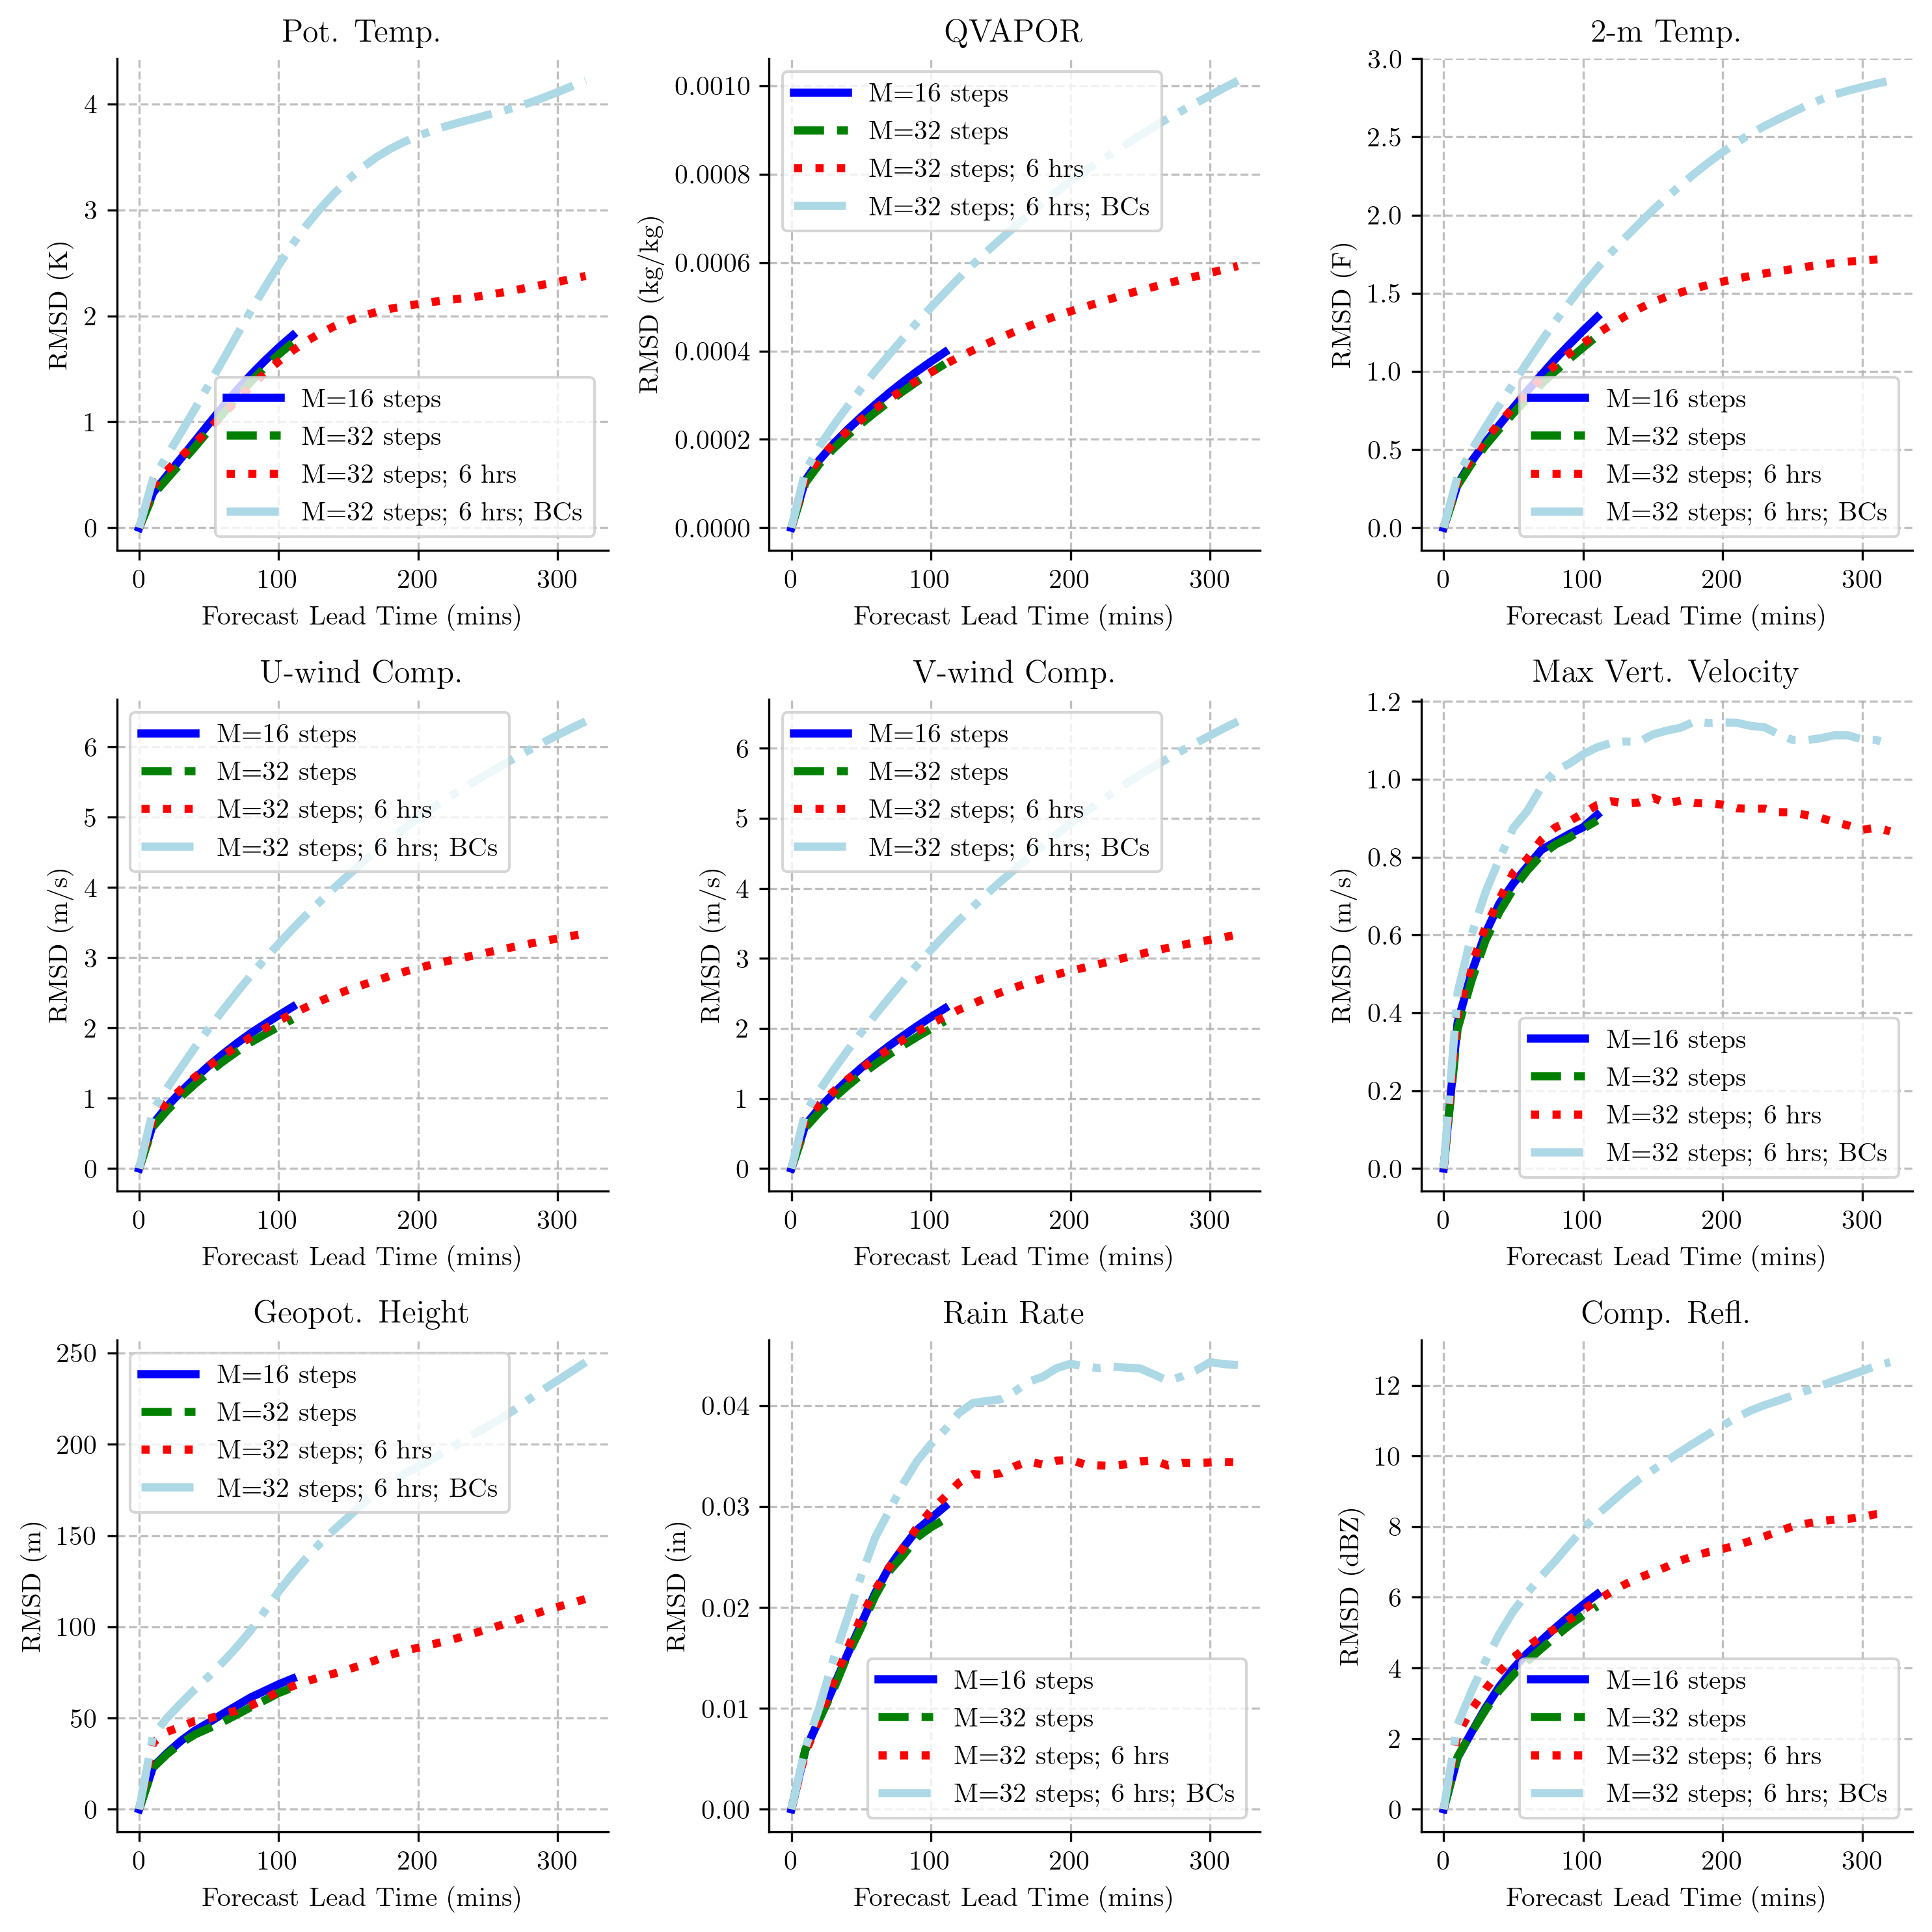

In [8]:
# Works!!!
plotter.plot_rmse(rmse_variables)

## WoFSCast vs. WoFS Composite Refl. Object Matching. 

(<Figure size 1500x900 with 2 Axes>,
 <Axes: xlabel='Forecast Lead Time (mins)', ylabel='Score'>)

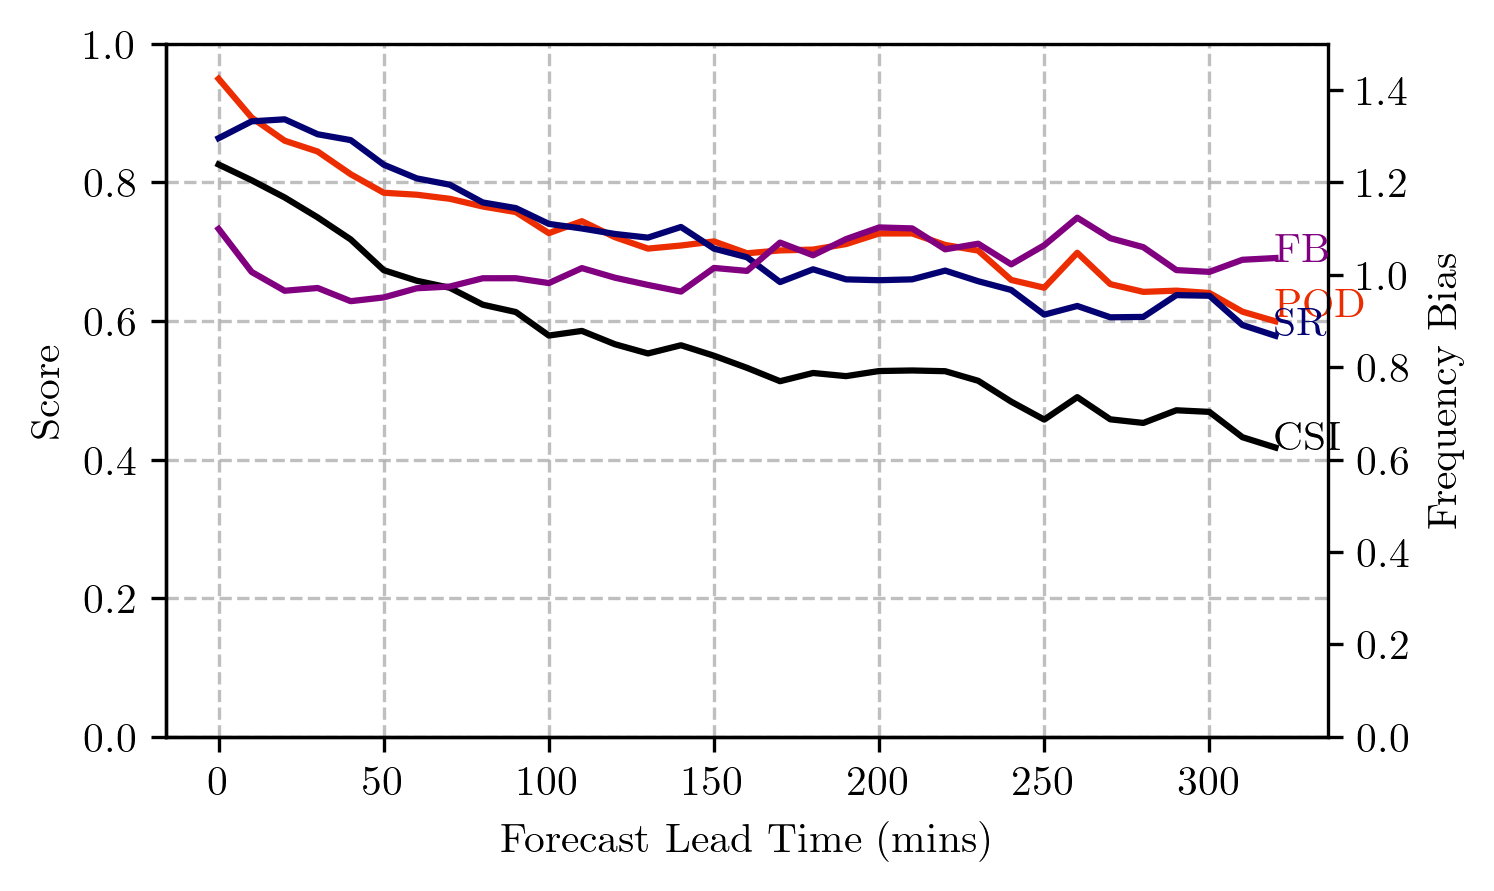

In [34]:
# Works!!
plotter.plot_obj_verify(dataset_name=dataset_name, add_fb_ax=True)

## WoFSCast, WoFS, and MRMS 

(<Figure size 1500x1800 with 3 Axes>, <Axes: ylabel='Skill Score'>)

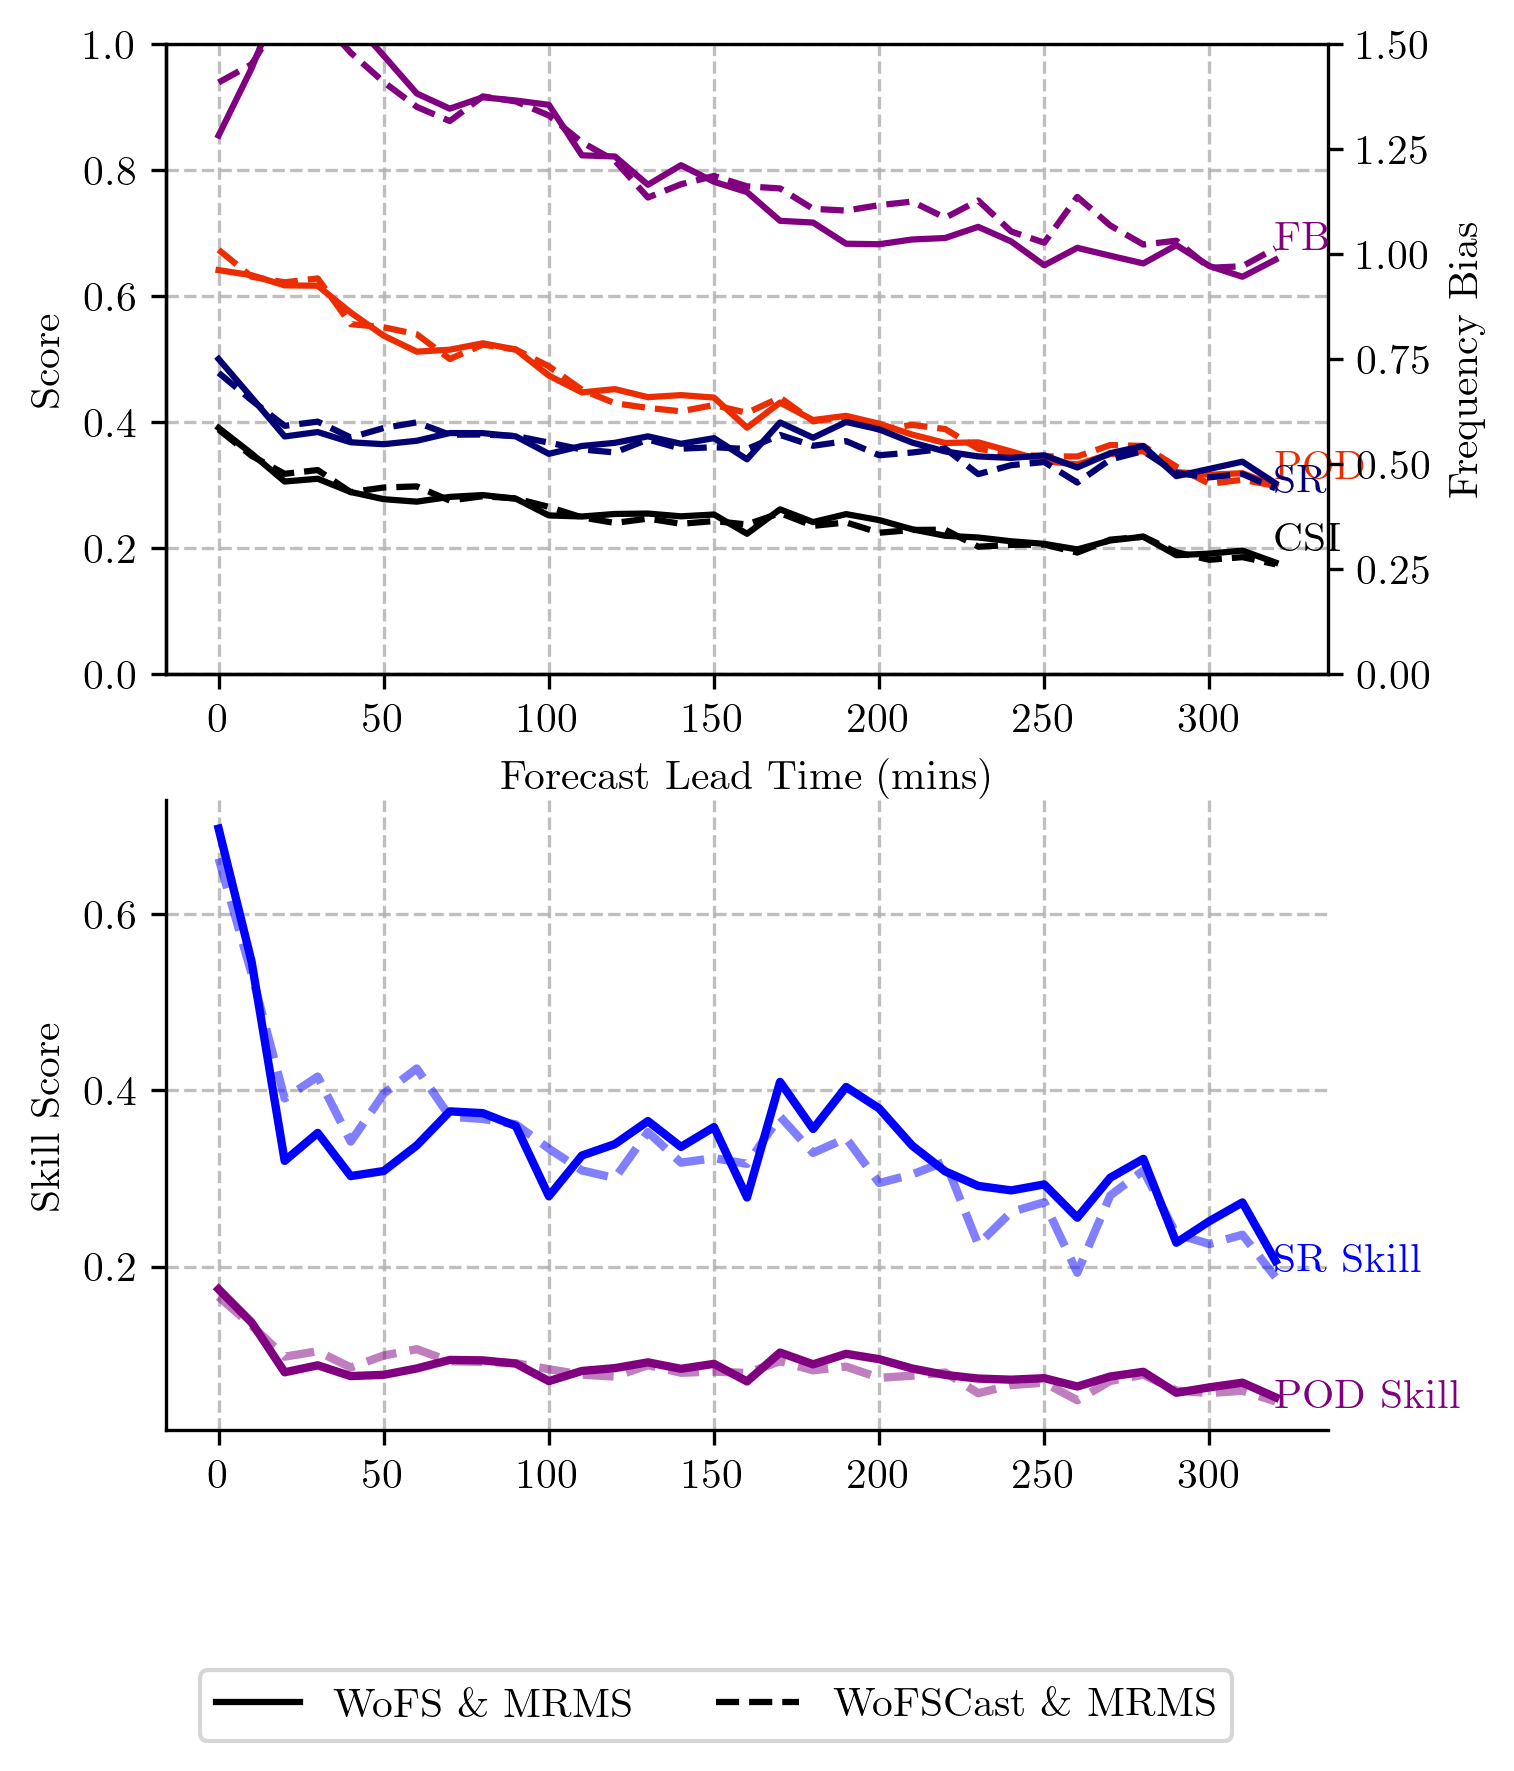

In [35]:
# Works !!
plotter.plot_obj_verify(
                        # NOTE: Do not reverse the order of these keys; the legend and line styles
                        # are assumin this order!!
                        dataset_name = dataset_name,
                        keys = ['targets_vs_mrms', 'forecasts_vs_mrms'], 
                        metrics = ['pod', 'sr', 'csi', 'fb'], 
                        add_skill= True, 
                        add_fb_ax = True,
                        f = 0.20, # Assumed base rate!!
                        x_bar = 0.5 # Assumed predicted frequency
                       )

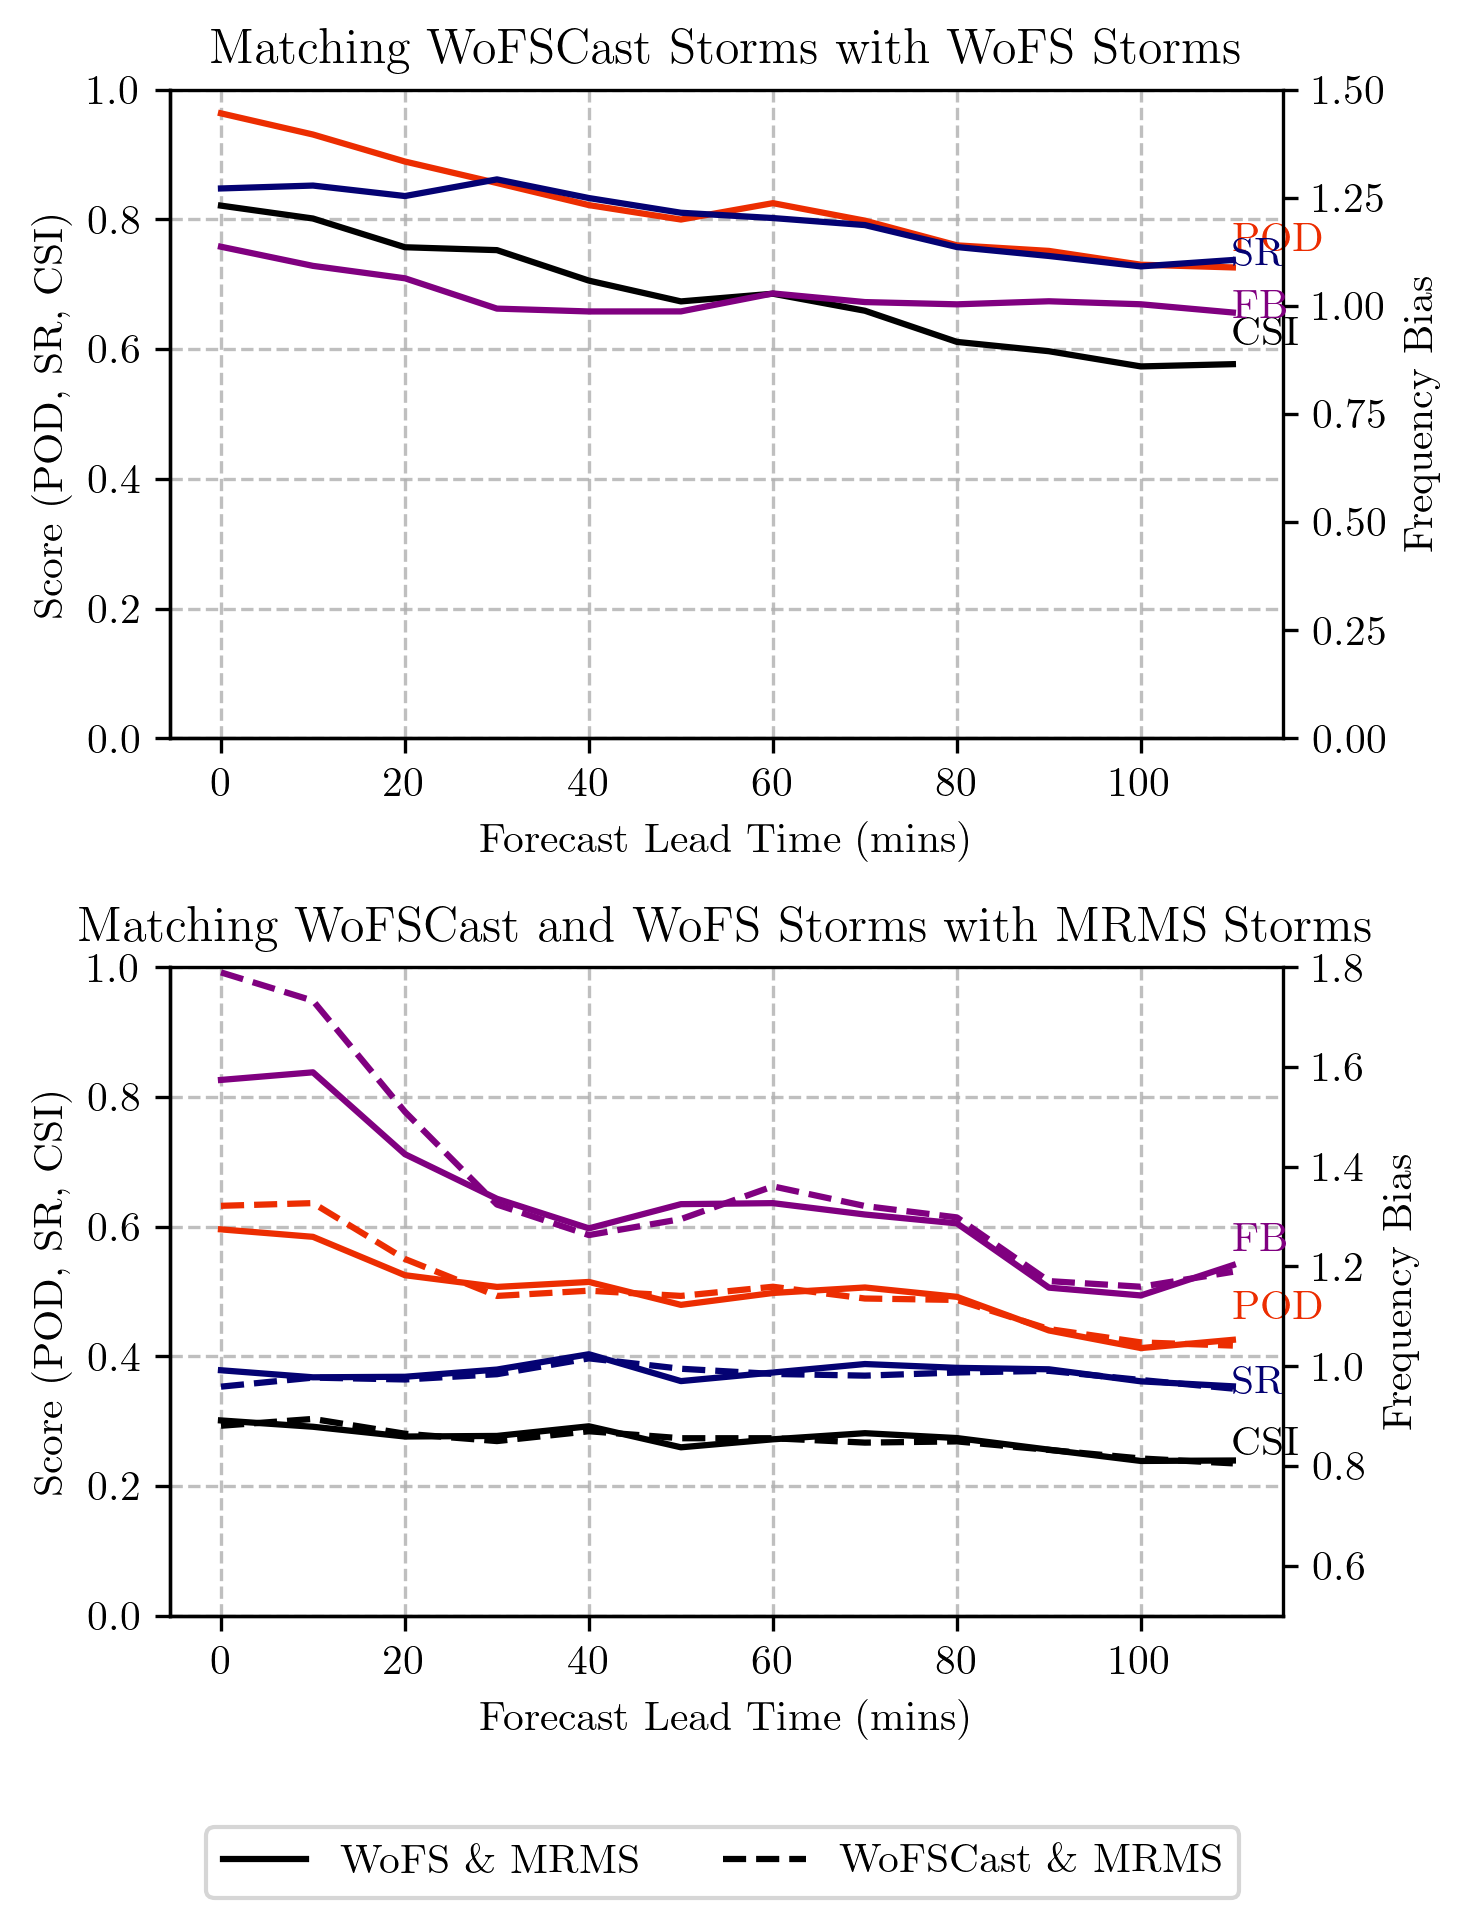

In [8]:
fig, axes = plt.subplots(dpi=300, nrows=2, figsize=(5,6))

# Works!!
plotter.plot_obj_verify(dataset_name=dataset_name, add_fb_ax=True, ax=axes[0], fig=fig)

plotter.plot_obj_verify(
                        # NOTE: Do not reverse the order of these keys; the legend and line styles
                        # are assumin this order!!
                        dataset_name = dataset_name,
                        keys = ['targets_vs_mrms', 'forecasts_vs_mrms'], 
                        metrics = ['pod', 'sr', 'csi', 'fb'], 
                        add_skill= False, 
                        add_fb_ax = True,
                        f = 0.20, # Assumed base rate!!
                        x_bar = 0.5, # Assumed predicted frequency,
                        ax = axes[1],
                        fig=fig,
                        fb_rng = [0.5, 1.8]
                       )

axes[0].set_title('Matching WoFSCast Storms with WoFS Storms')
axes[1].set_title('Matching WoFSCast and WoFS Storms with MRMS Storms')

for ax in axes:
    ax.set_ylabel('Score (POD, SR, CSI)')

plt.tight_layout()

## Power Spectra 

(<Figure size 3000x2400 with 6 Axes>,
 array([[<Axes: title={'center': 'Comp. Refl.'}, xlabel='Wavenumber', ylabel='Spectral Density'>,
         <Axes: title={'center': '2-m Temp.'}, xlabel='Wavenumber'>,
         <Axes: title={'center': 'Vert. Velocity'}, xlabel='Wavenumber'>],
        [<Axes: xlabel='Wavenumber', ylabel='Forecast / Truth Ratio'>,
         <Axes: xlabel='Wavenumber'>, <Axes: xlabel='Wavenumber'>]],
       dtype=object))

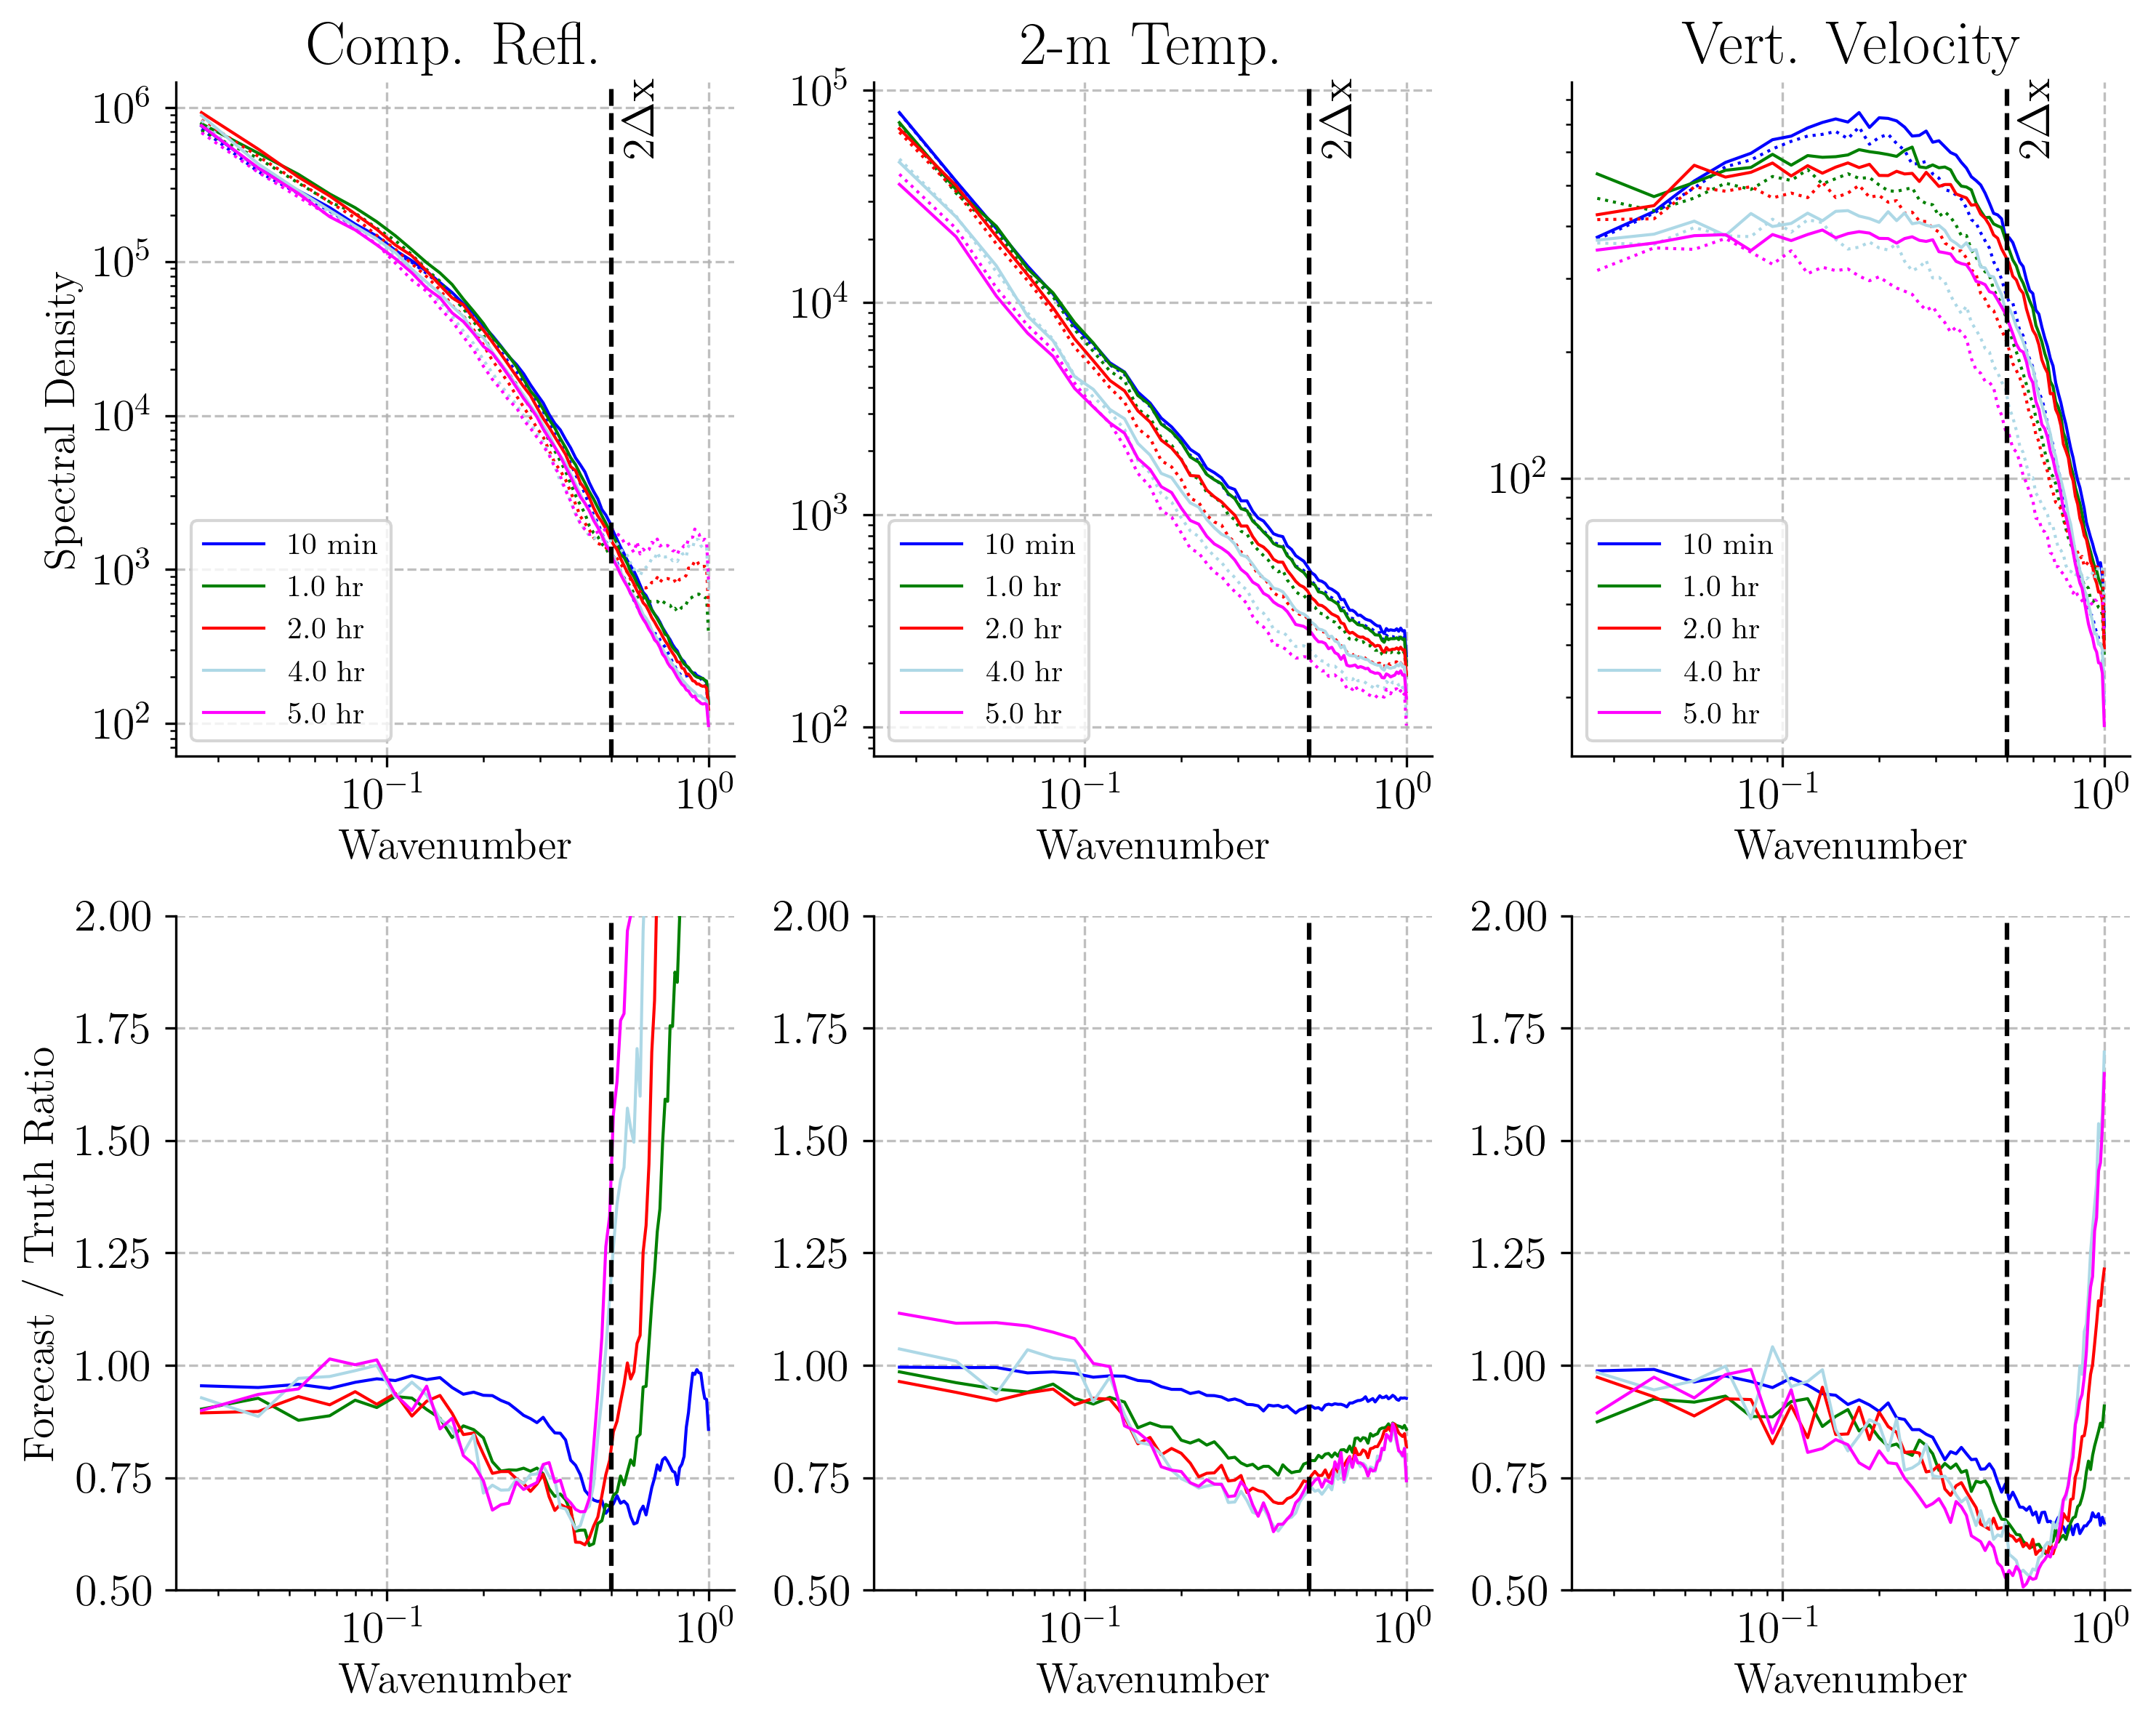

In [42]:
# Works!!
plotter.plot_spectra(dataset_name, spectra_variables, desired_times=[10, 60, 120, 240,300])

(<Figure size 3000x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Comp. Refl.'}, xlabel='Forecast Lead Time (mins)', ylabel='Integrated Spectral Ratio Diff. \n(Closer to Zero Better)'>,
        <Axes: title={'center': '2-m Temp.'}, xlabel='Forecast Lead Time (mins)', ylabel='Integrated Spectral Ratio Diff. \n(Closer to Zero Better)'>,
        <Axes: title={'center': 'Vert. Velocity'}, xlabel='Forecast Lead Time (mins)', ylabel='Integrated Spectral Ratio Diff. \n(Closer to Zero Better)'>],
       dtype=object))

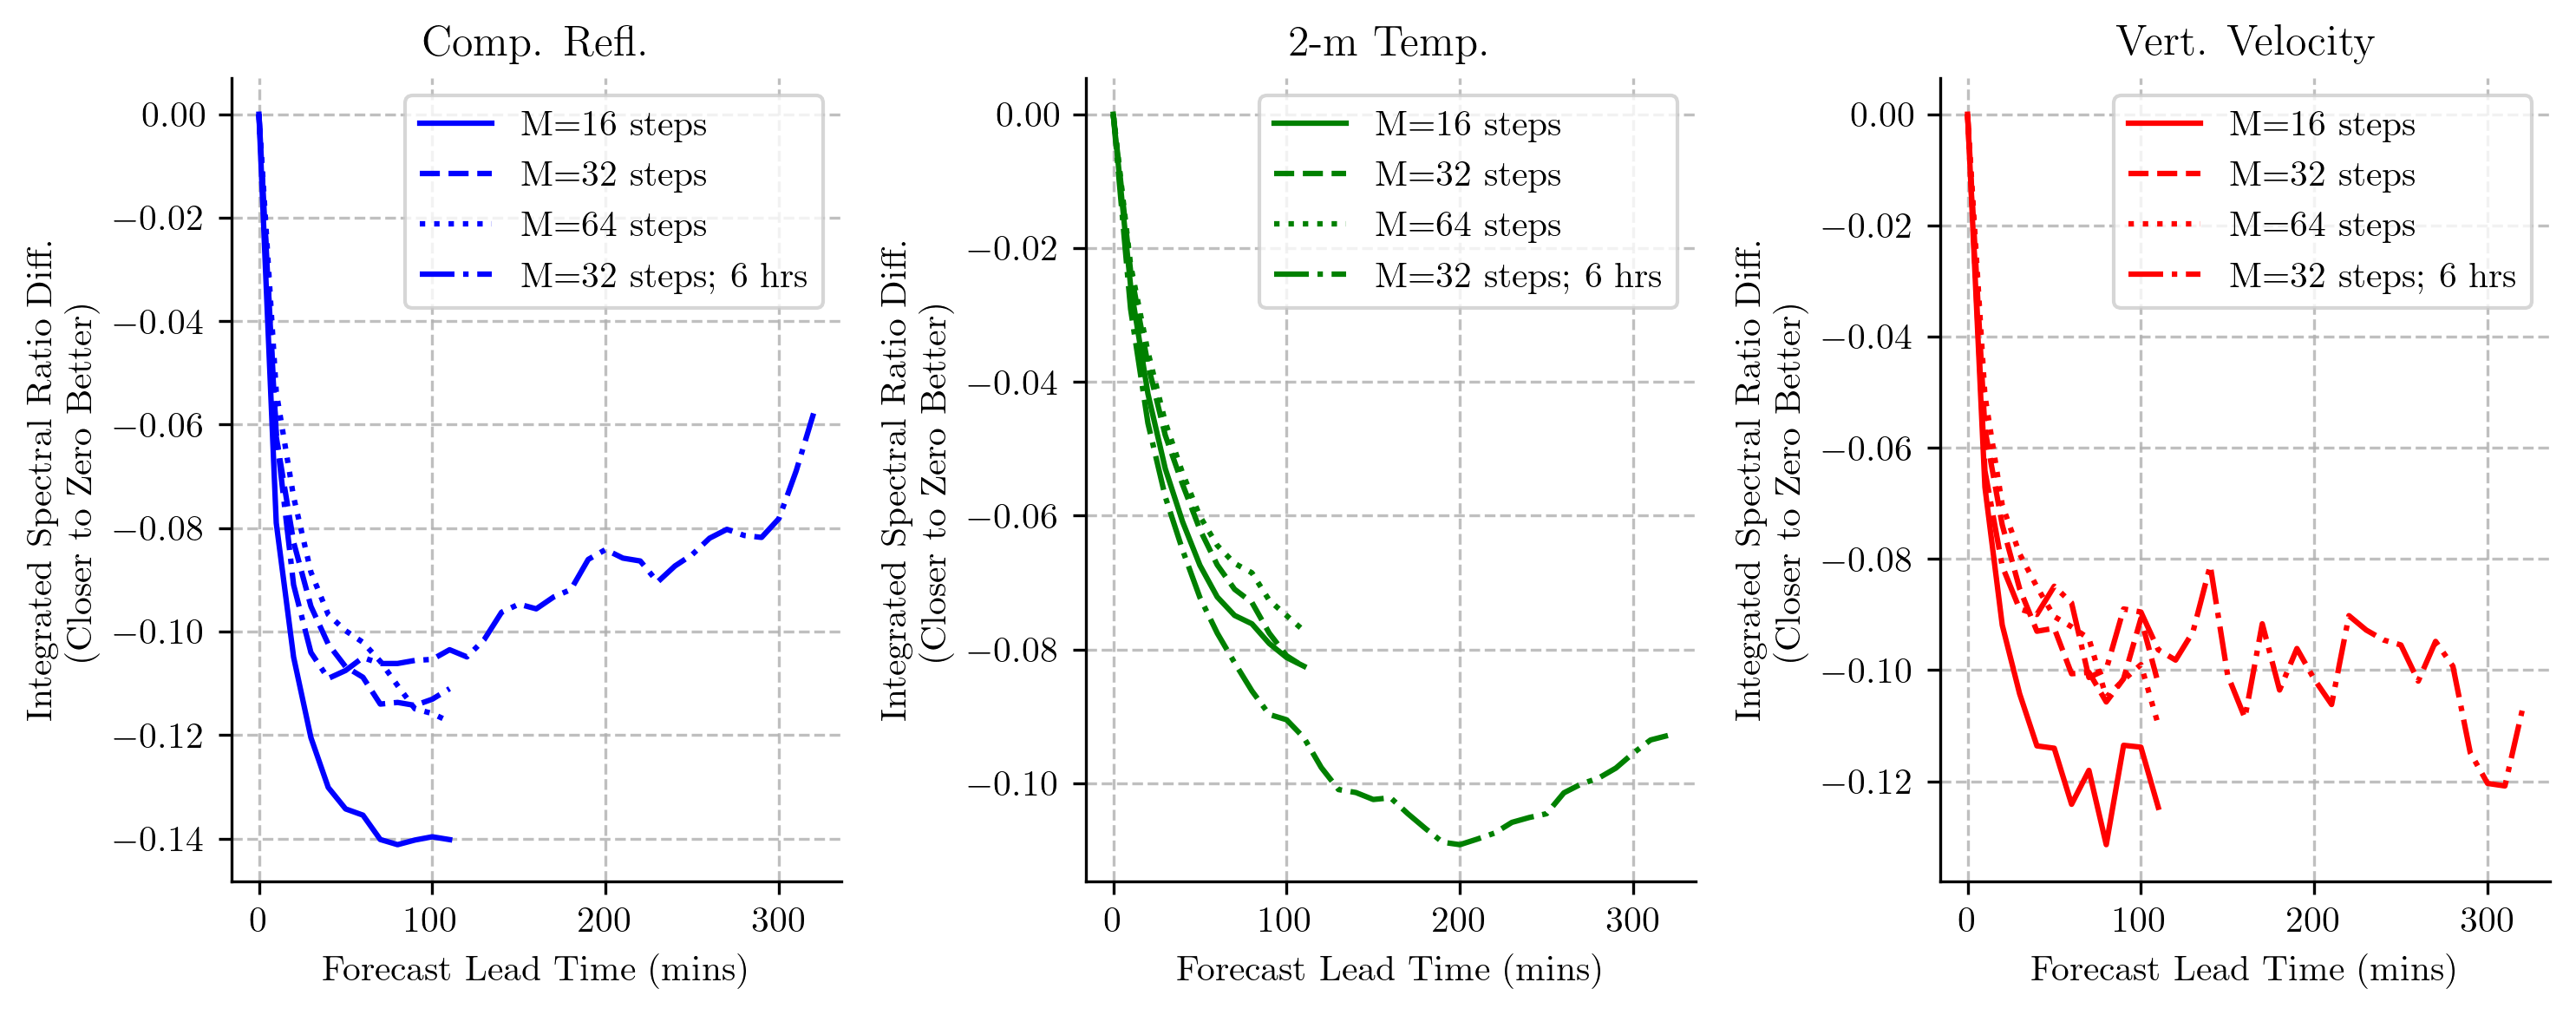

In [45]:
plotter.plot_spectra_sharpness(spectra_variables)

## Probability Matched Mean Storm Structure Assessment 

/tmp/ipykernel_528875/1263254296.py:366: UserWarning: The following kwargs were not used by contour: 'aspect'
  im3 = axs[2].contourf(difference, origin='lower', aspect='equal',


(<Figure size 3000x4200 with 20 Axes>,
 array([[<Axes: title={'center': 'WoFSCast Comp. Refl. (N=113)'}>,
         <Axes: title={'center': 'WoFS Comp. Refl. (N=113)'}>,
         <Axes: title={'center': 'WoFSCast - WoFS'}>],
        [<Axes: title={'center': 'WoFSCast Rain Rate (N=113)'}>,
         <Axes: title={'center': 'WoFS Rain Rate (N=113)'}>,
         <Axes: title={'center': 'WoFSCast - WoFS'}>],
        [<Axes: title={'center': 'WoFSCast 2-m Temp. (N=113)'}>,
         <Axes: title={'center': 'WoFS 2-m Temp. (N=113)'}>,
         <Axes: title={'center': 'WoFSCast - WoFS'}>],
        [<Axes: title={'center': 'WoFSCast Max Updraft (N=113)'}>,
         <Axes: title={'center': 'WoFS Max Updraft (N=113)'}>,
         <Axes: title={'center': 'WoFSCast - WoFS'}>]], dtype=object))

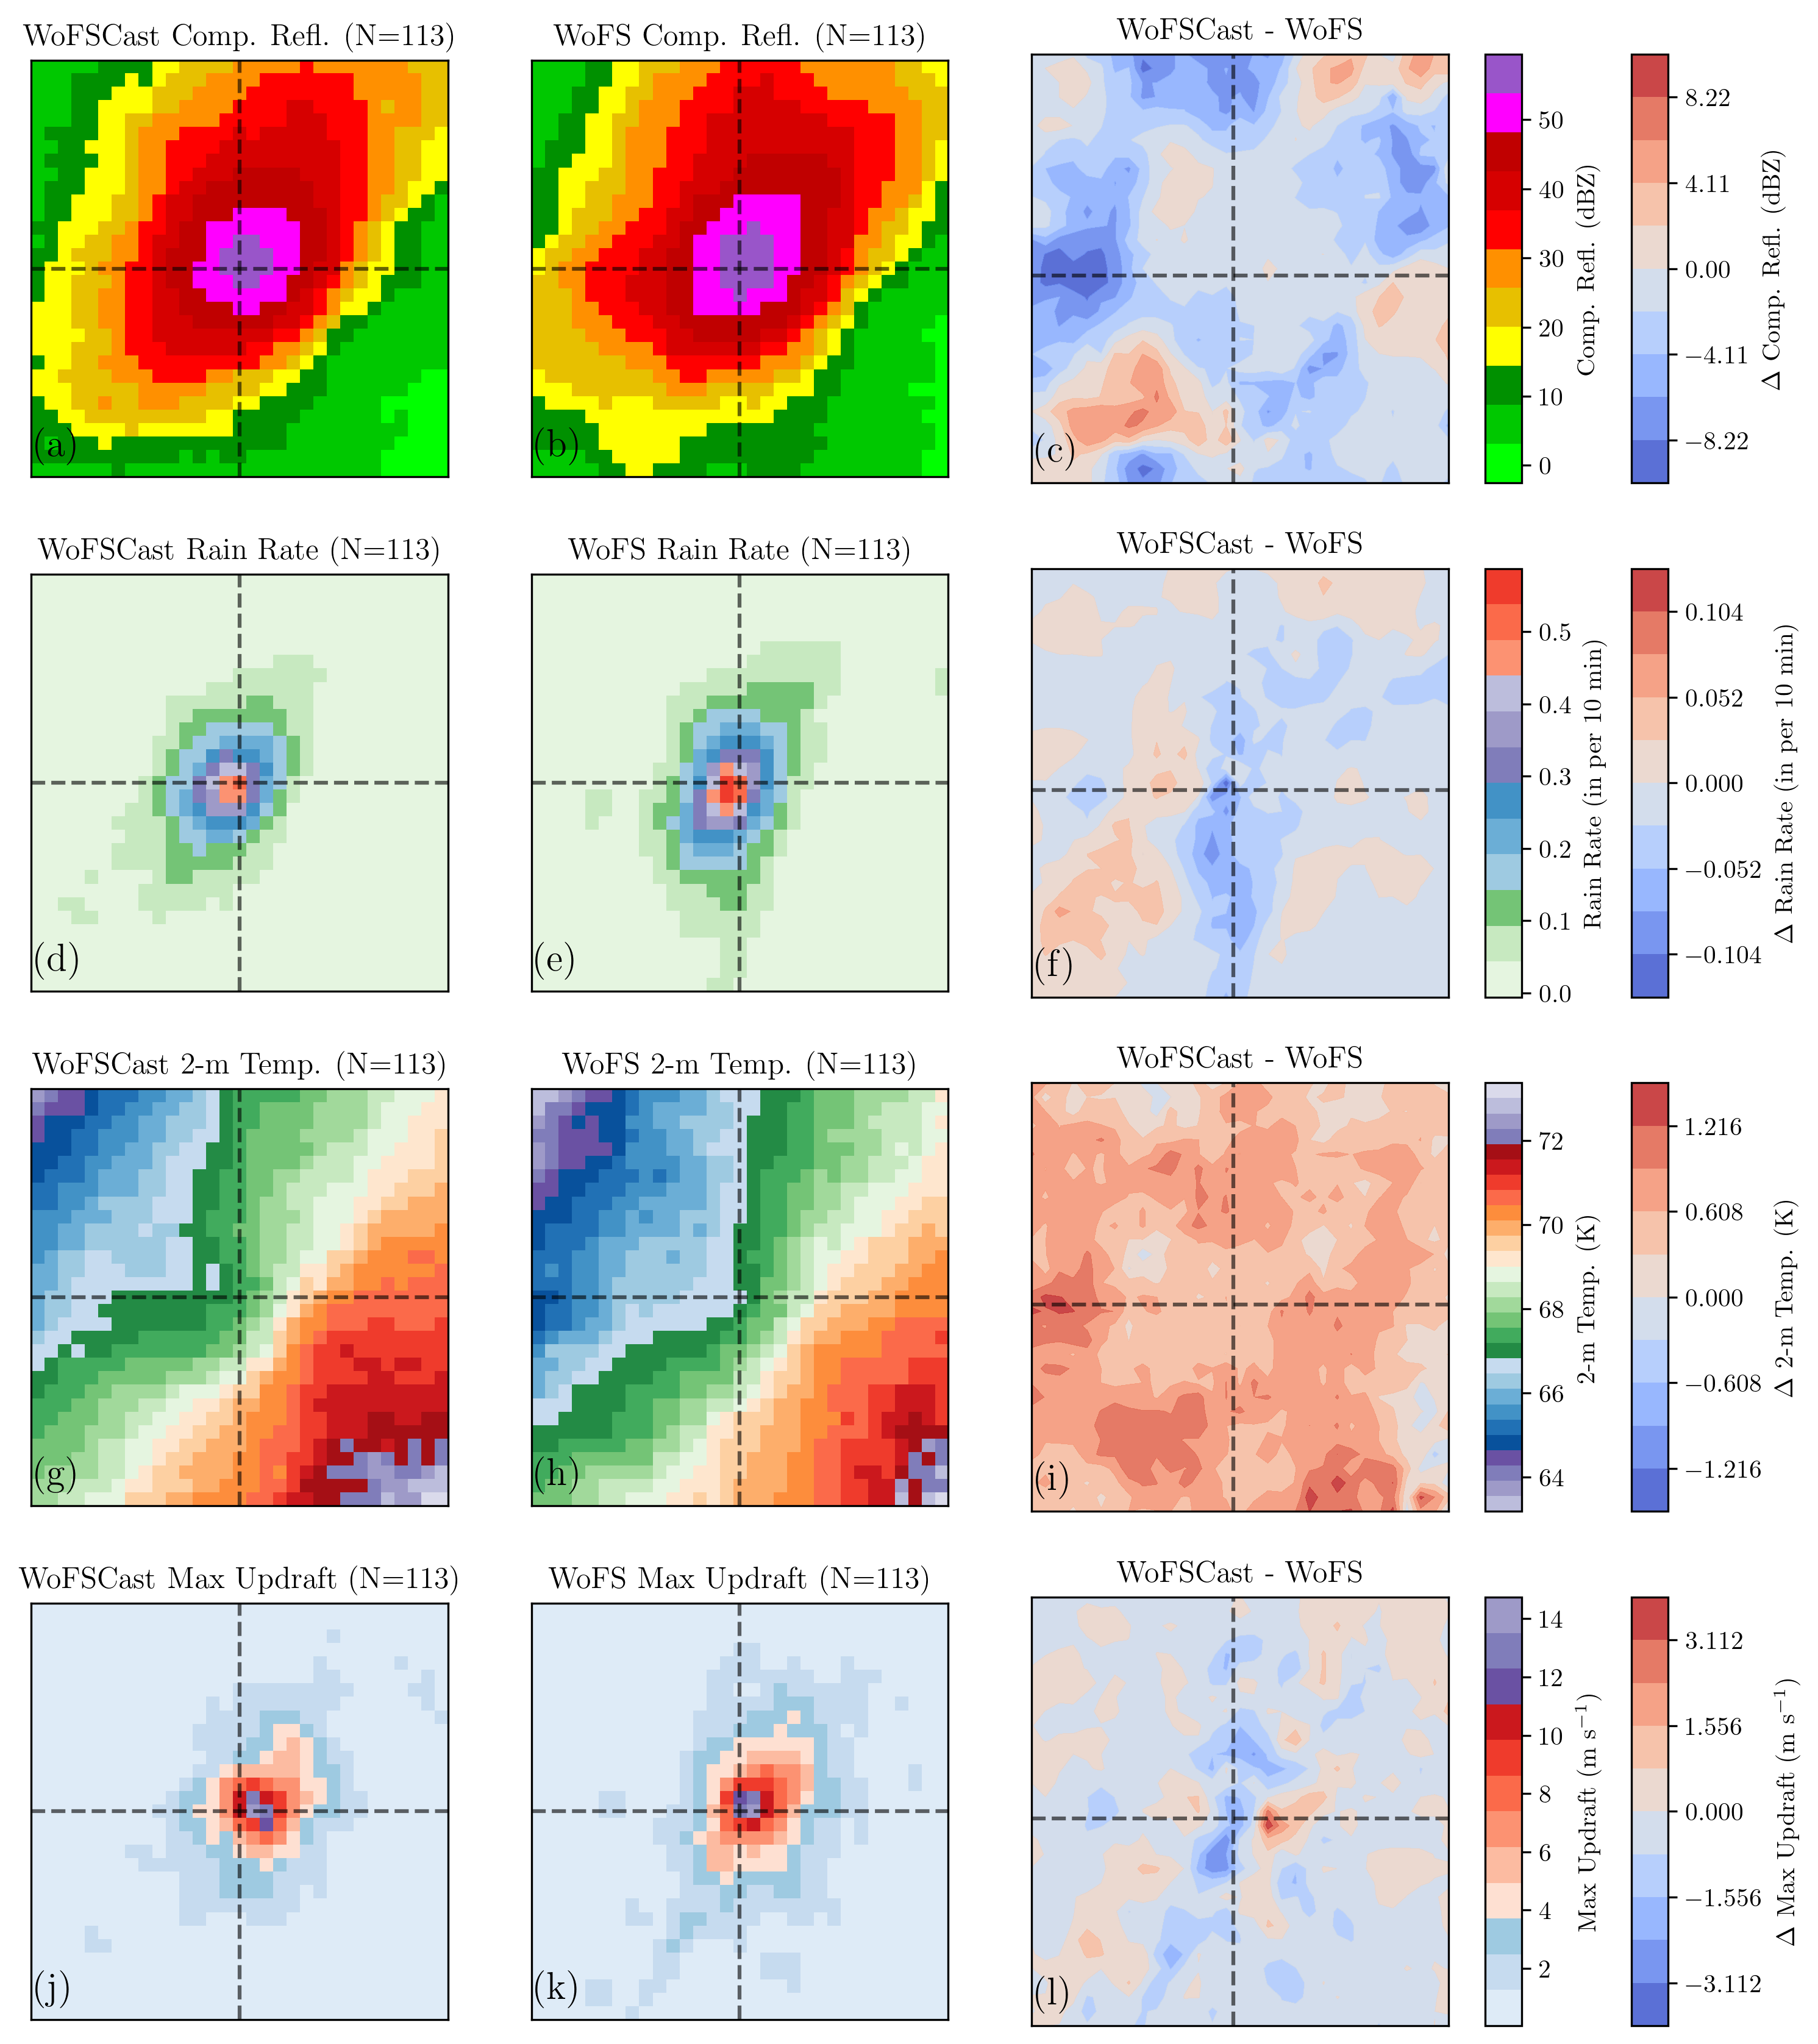

In [46]:
# Works! 
plotter.plot_pmm_patches(dataset_name, variables=pmm_variables, time_idx=-1)

(<Figure size 1920x1440 with 4 Axes>,
 array([[<Axes: title={'center': 'Comp. Refl.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (dBZ)'>,
         <Axes: title={'center': 'Rain Rate'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (in)'>],
        [<Axes: title={'center': '2-m Temp.'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (F)'>,
         <Axes: title={'center': 'Max Vert. Velocity'}, xlabel='Forecast Lead Time (mins)', ylabel='RMSD (m/s)'>]],
       dtype=object))

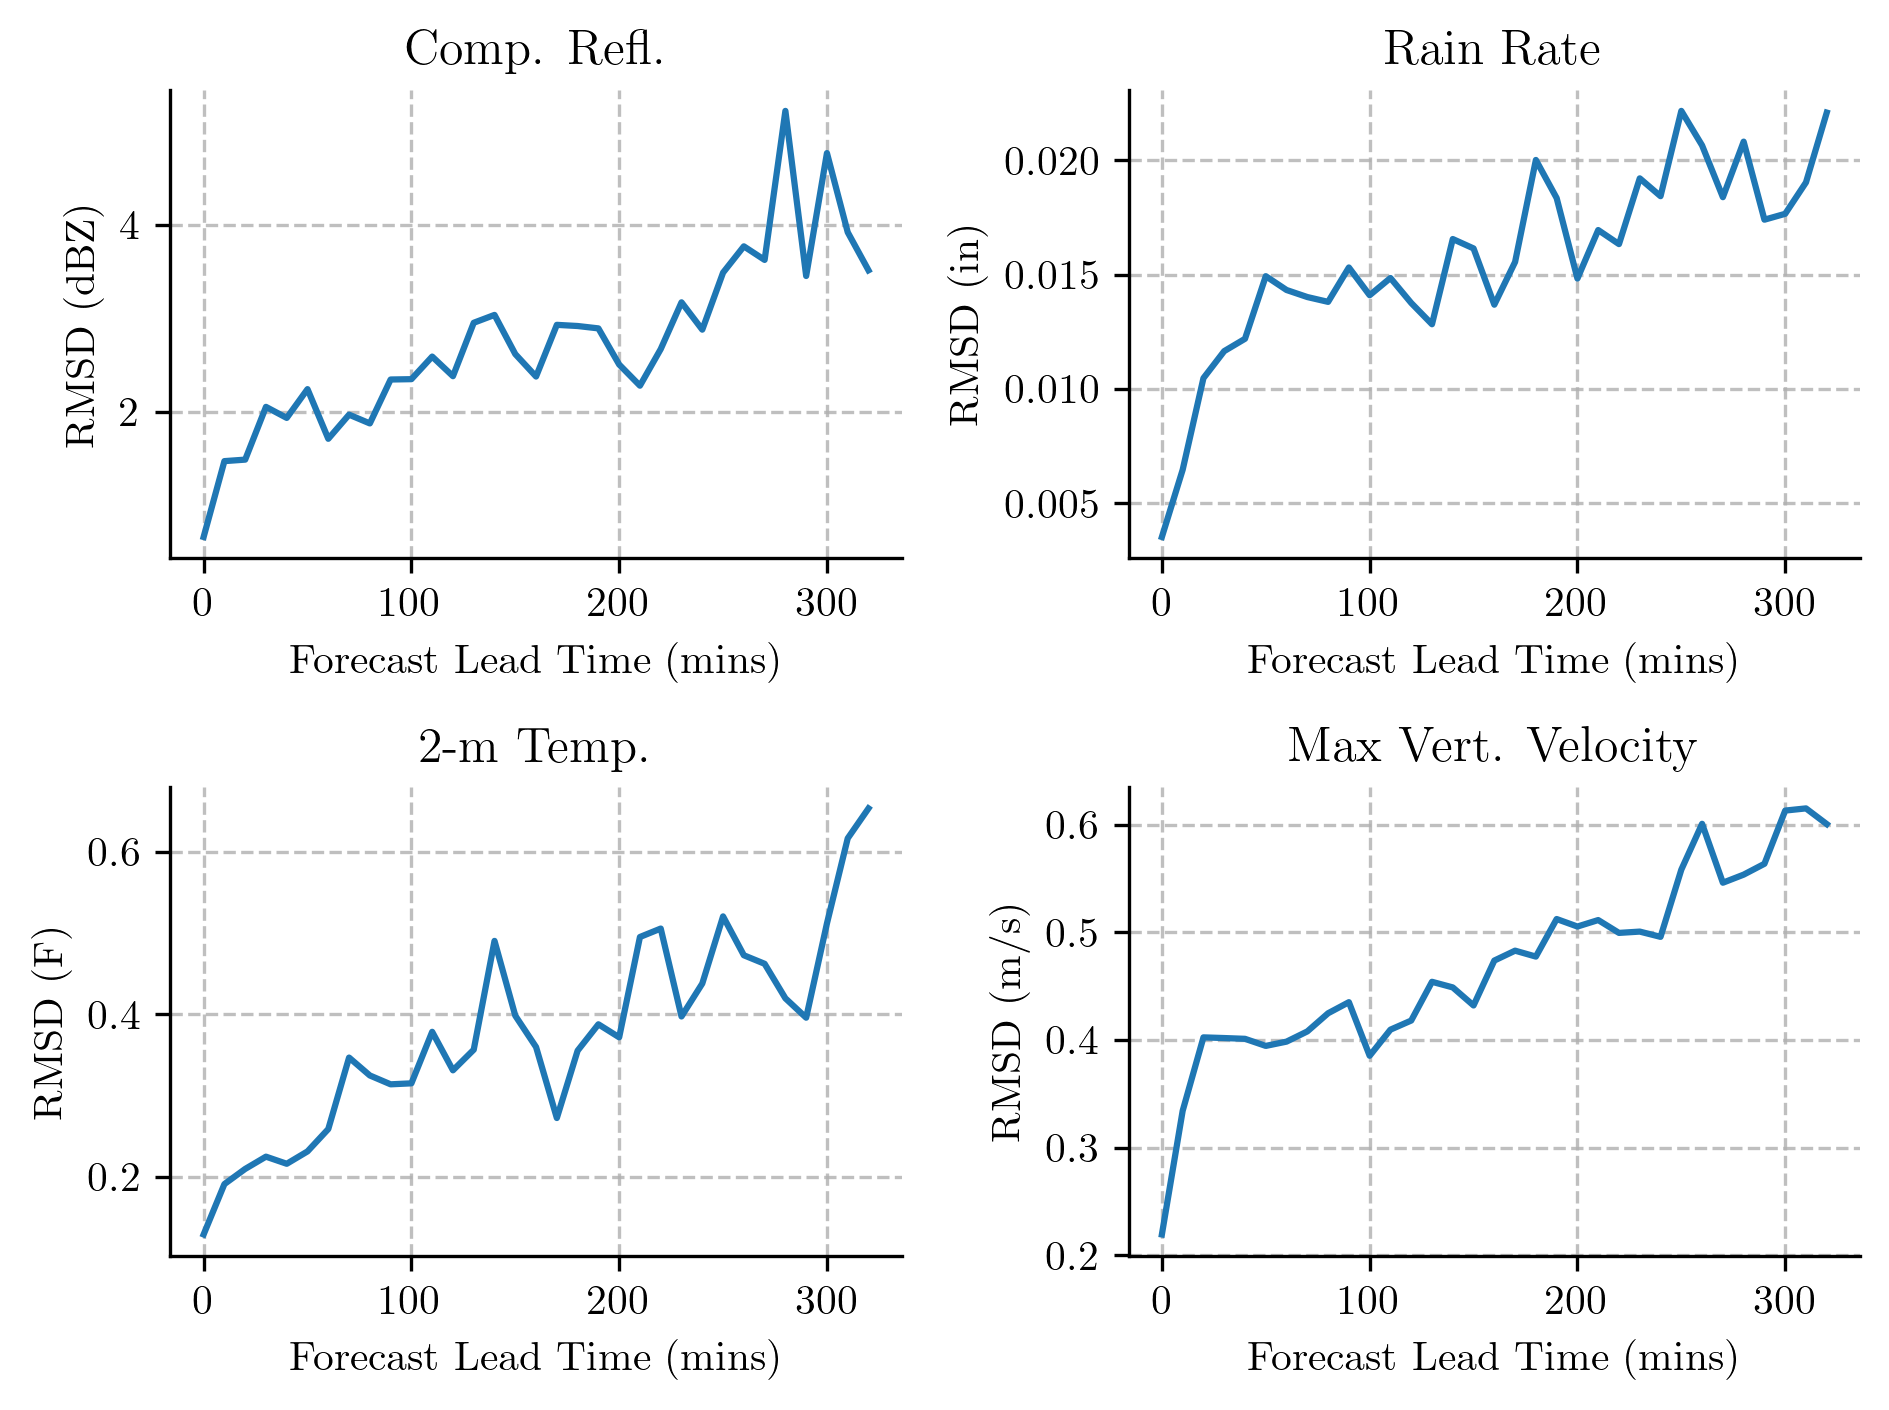

In [47]:
# Works!
plotter.plot_pmm_rmse(dataset_name, pmm_variables)

## Quantile Ratio plot 

## PMM Taylor Diagram!!!

bias=array([-0.21045299])


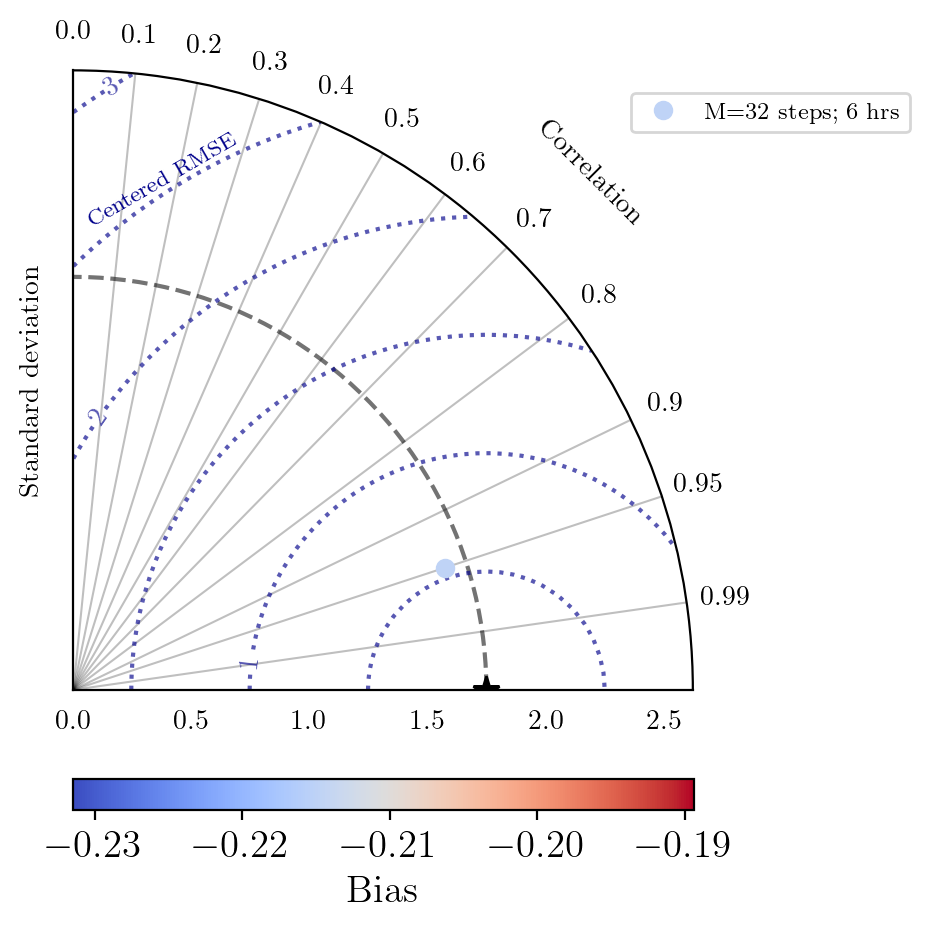

In [48]:
plotter.plot_taylor_diagram(dataset_name, 'WMAX', time_idx=-1,
                            rmse_contours= np.arange(0, 50, 0.5), n_boot=10)

bias=array([-2.03521503])


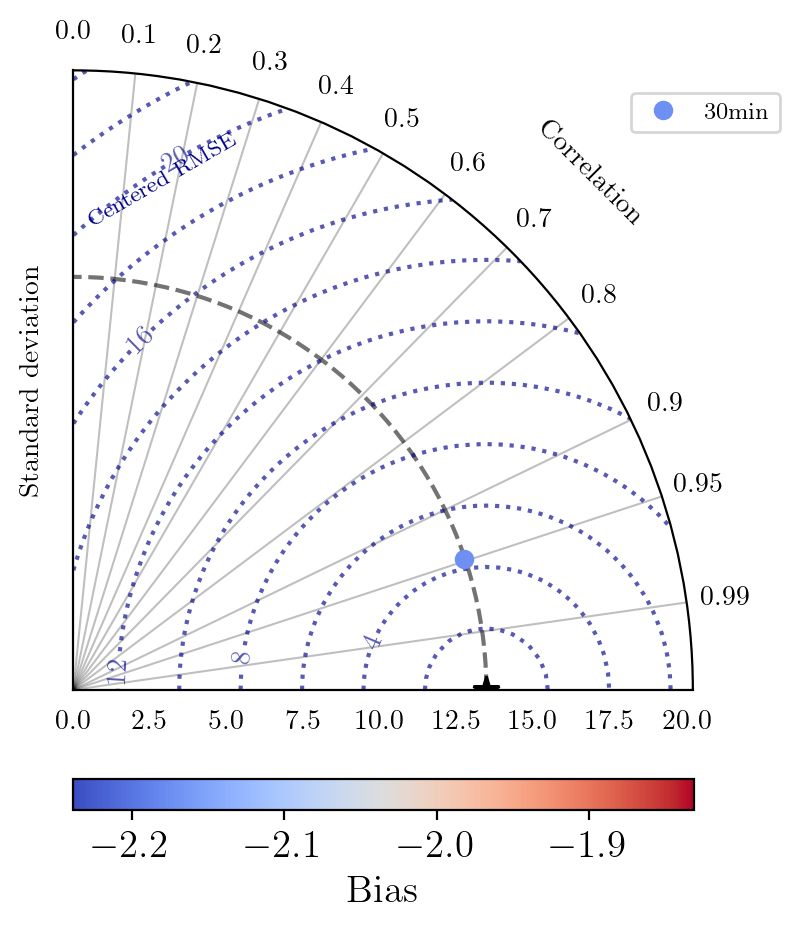

In [14]:
plotter.plot_taylor_diagram(dataset_name, 'COMPOSITE_REFL_10CM', time_idx=-1,
                            rmse_contours= np.arange(0, 40, 2.0), n_boot=10)

bias=array([0.43126362])


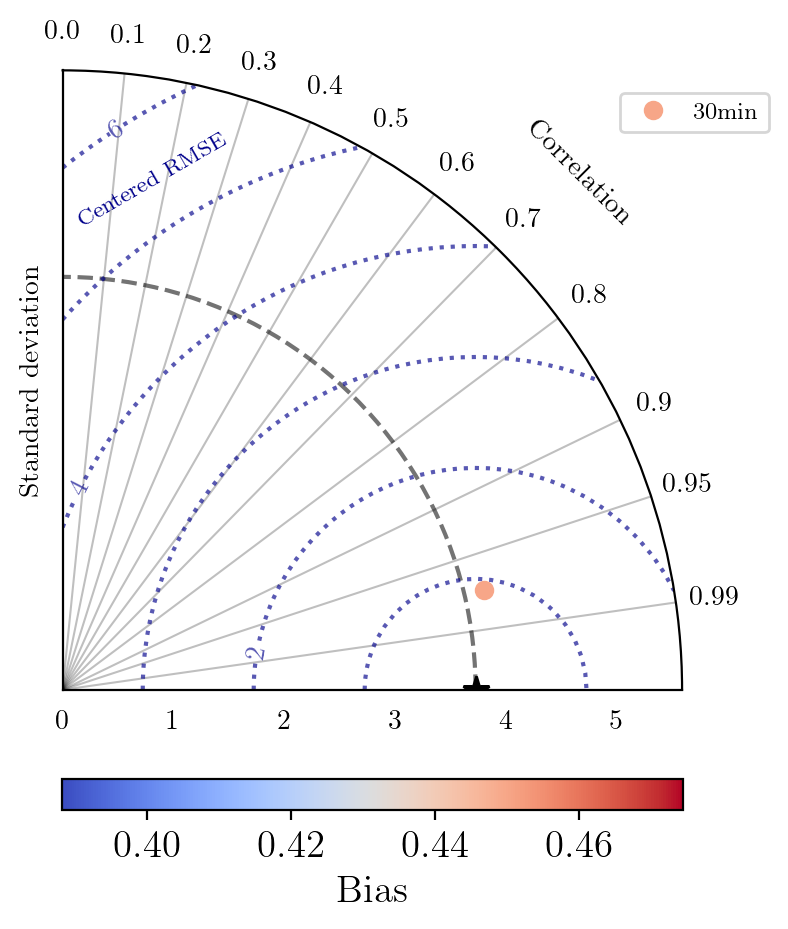

In [15]:
plotter.plot_taylor_diagram(dataset_name, 'T2', time_idx=-1,
                            rmse_contours= np.arange(0, 10, 1.0), n_boot=10)

bias=array([-0.00481956])


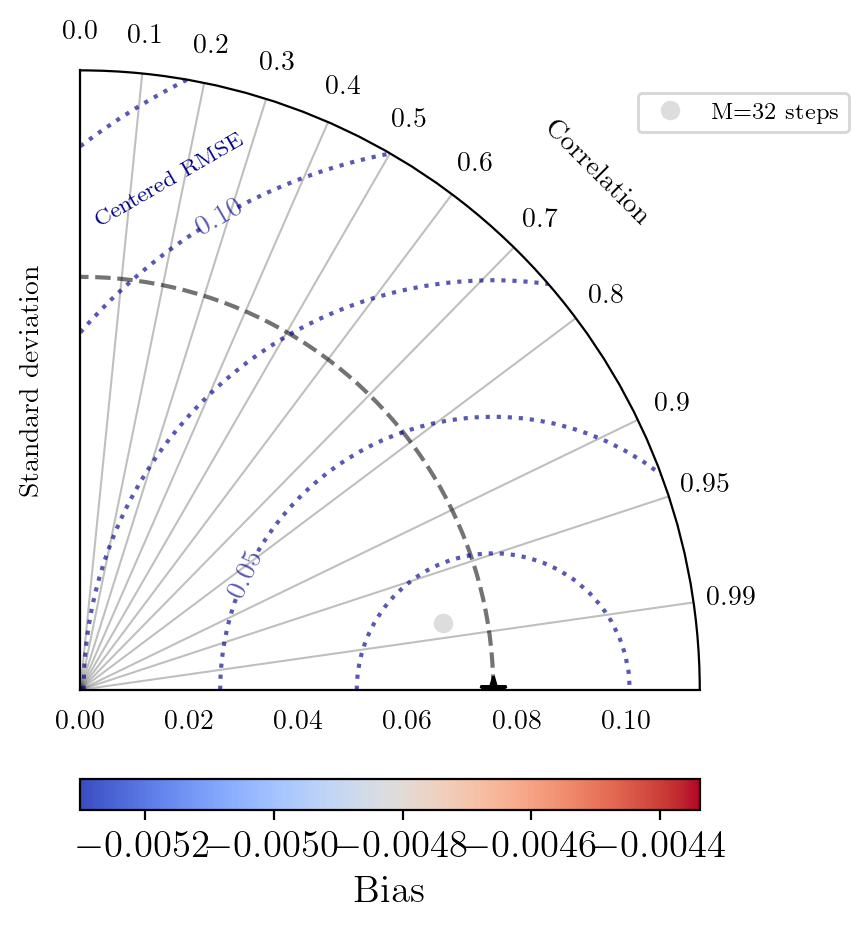

In [17]:
plotter.plot_taylor_diagram(dataset_name, 'RAIN_AMOUNT', time_idx=-1,
                            rmse_contours= np.arange(0, 2, 0.025), n_boot=10)

## Fractions Skill Score 

(<Figure size 1500x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Comp. Refl. $>$ 40.0 dBZ'}, xlabel='Forecast Lead Time (mins)', ylabel='Fractions Skill Score'>,
        <Axes: title={'center': 'Rain Rate $>$ 0.5 in per 10 min'}, xlabel='Forecast Lead Time (mins)', ylabel='Fractions Skill Score'>],
       dtype=object))

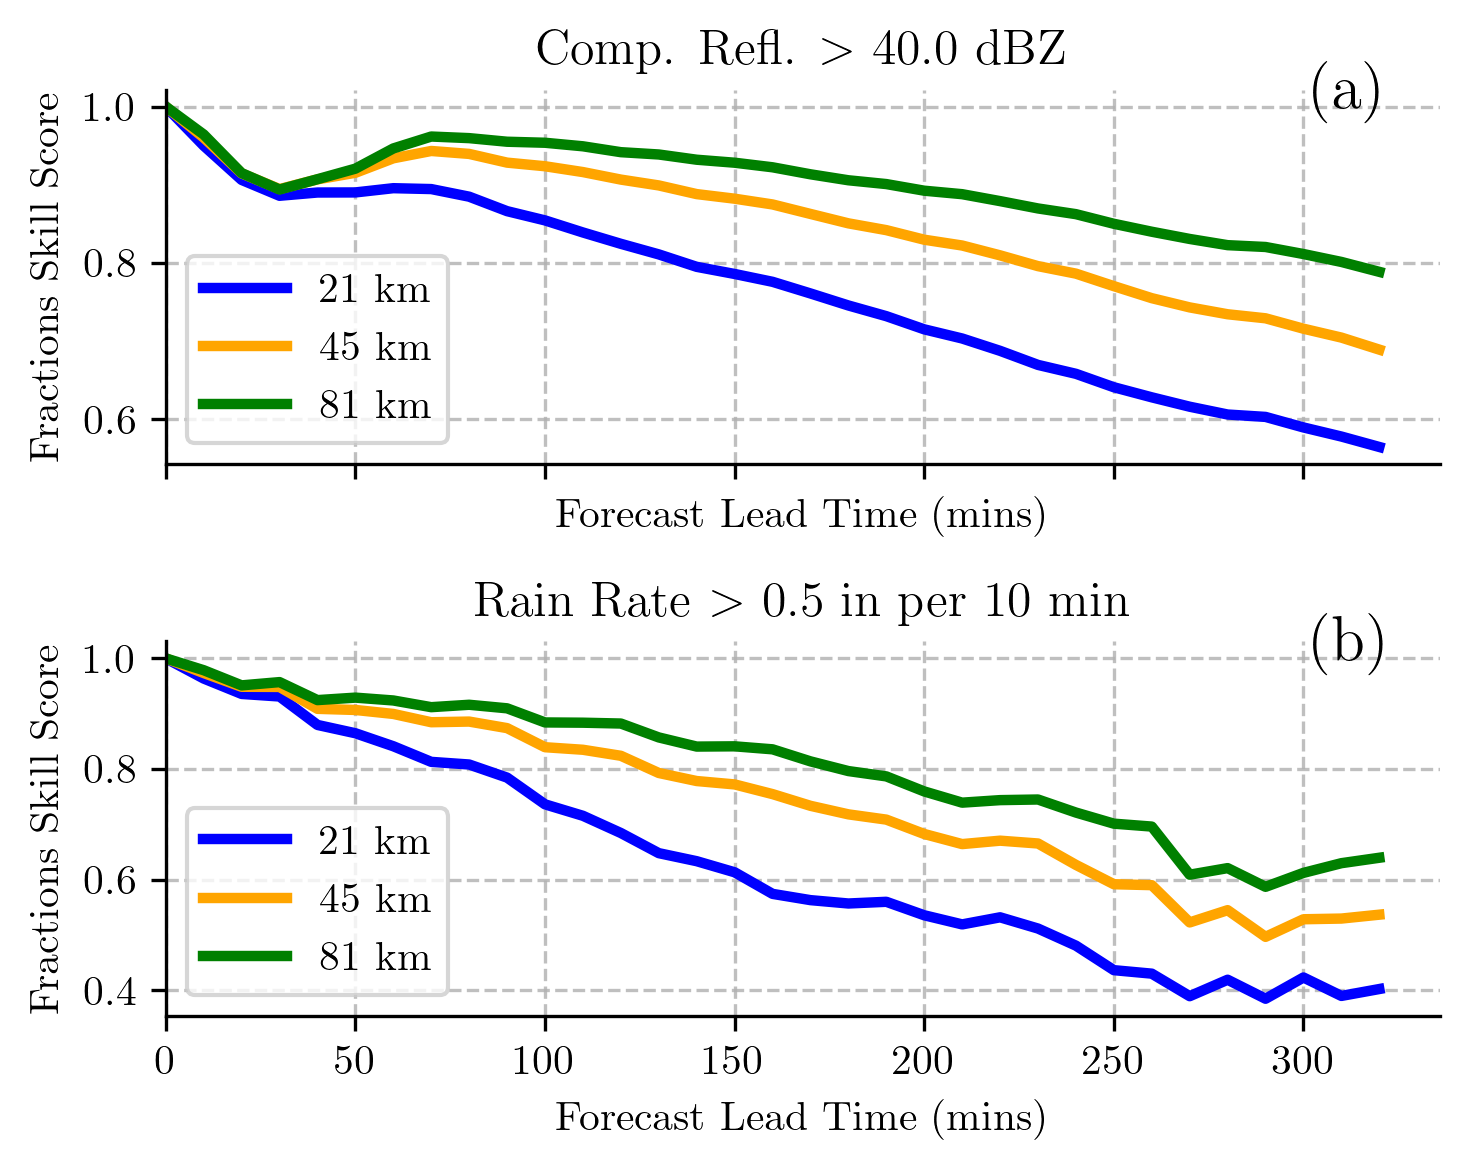

In [49]:
plotter.plot_fss(dataset_name, variables = ['COMPOSITE_REFL_10CM', 'RAIN_AMOUNT'])

(<Figure size 1500x1200 with 1 Axes>,
 <Axes: title={'center': 'Comp. Refl. $>$ 40.0 dBZ'}, xlabel='Forecast Lead Time (mins)', ylabel='Fractions Skill Score'>)

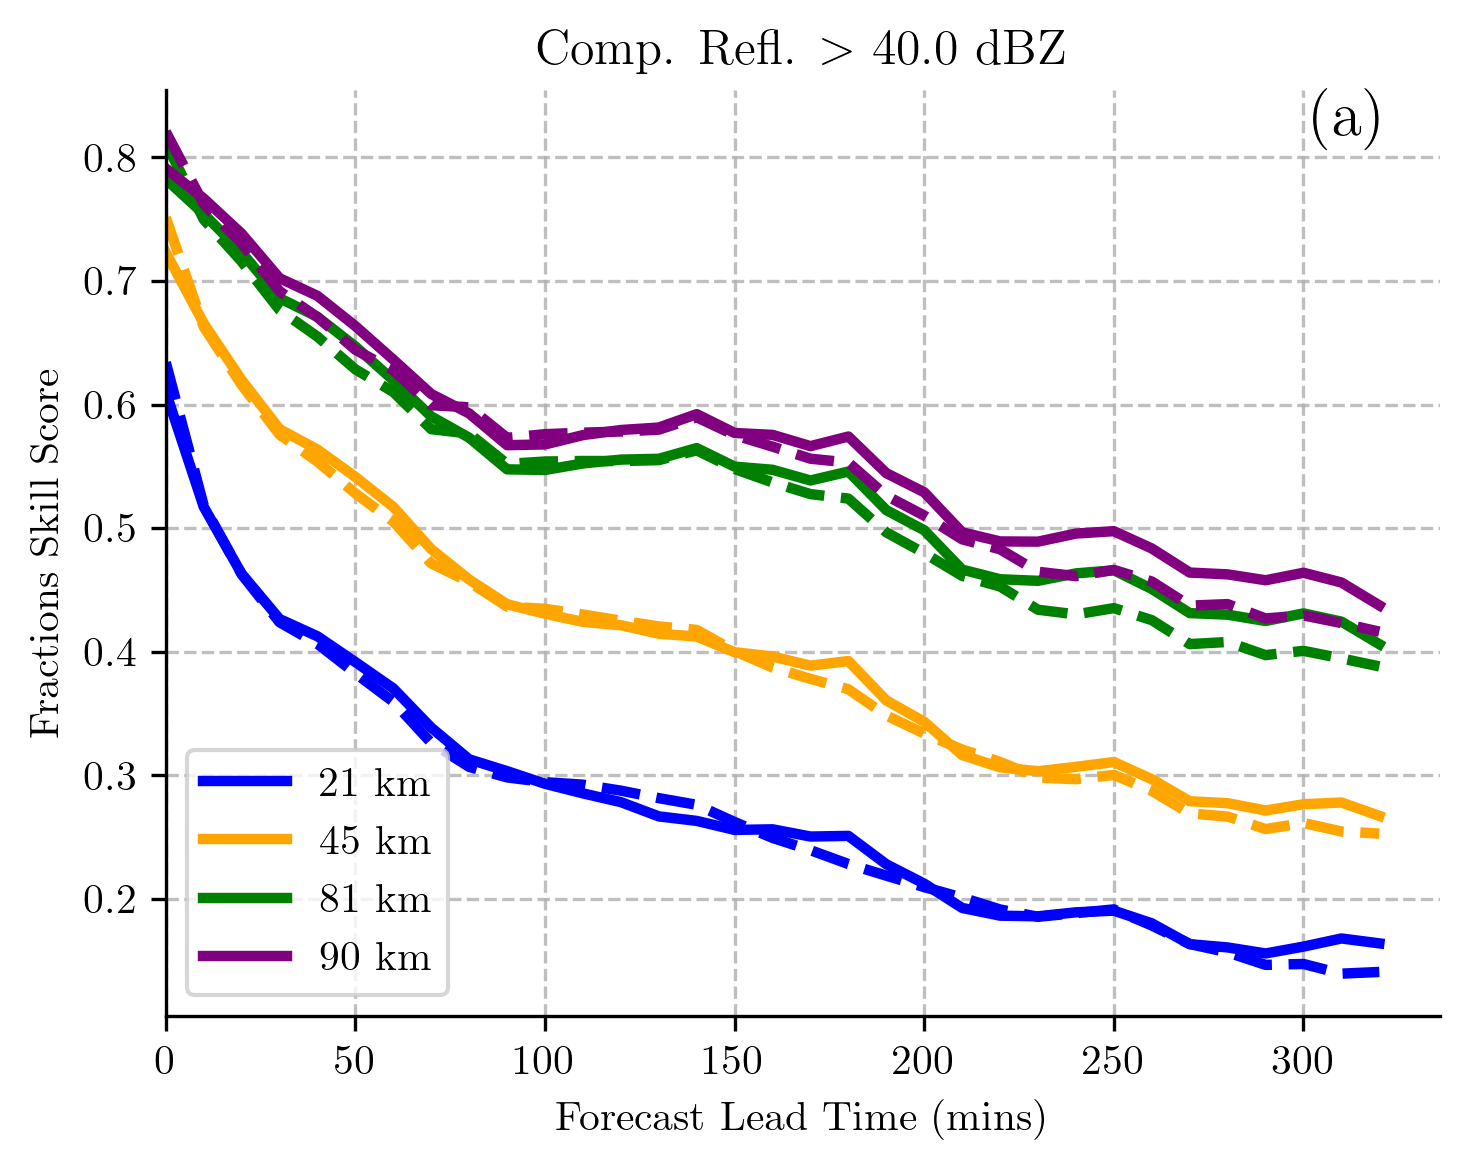

In [50]:
plotter.plot_fss(dataset_name, variables = ['COMPOSITE_REFL_10CM'], 
                 addons=['targets_vs_mrms', 'forecast_vs_mrms'])

(<Figure size 1500x1200 with 1 Axes>,
 <Axes: title={'center': 'Accum. Rainfall $>$ 0.5 in'}, xlabel='Forecast Lead Time (mins)', ylabel='Fractions Skill Score'>)

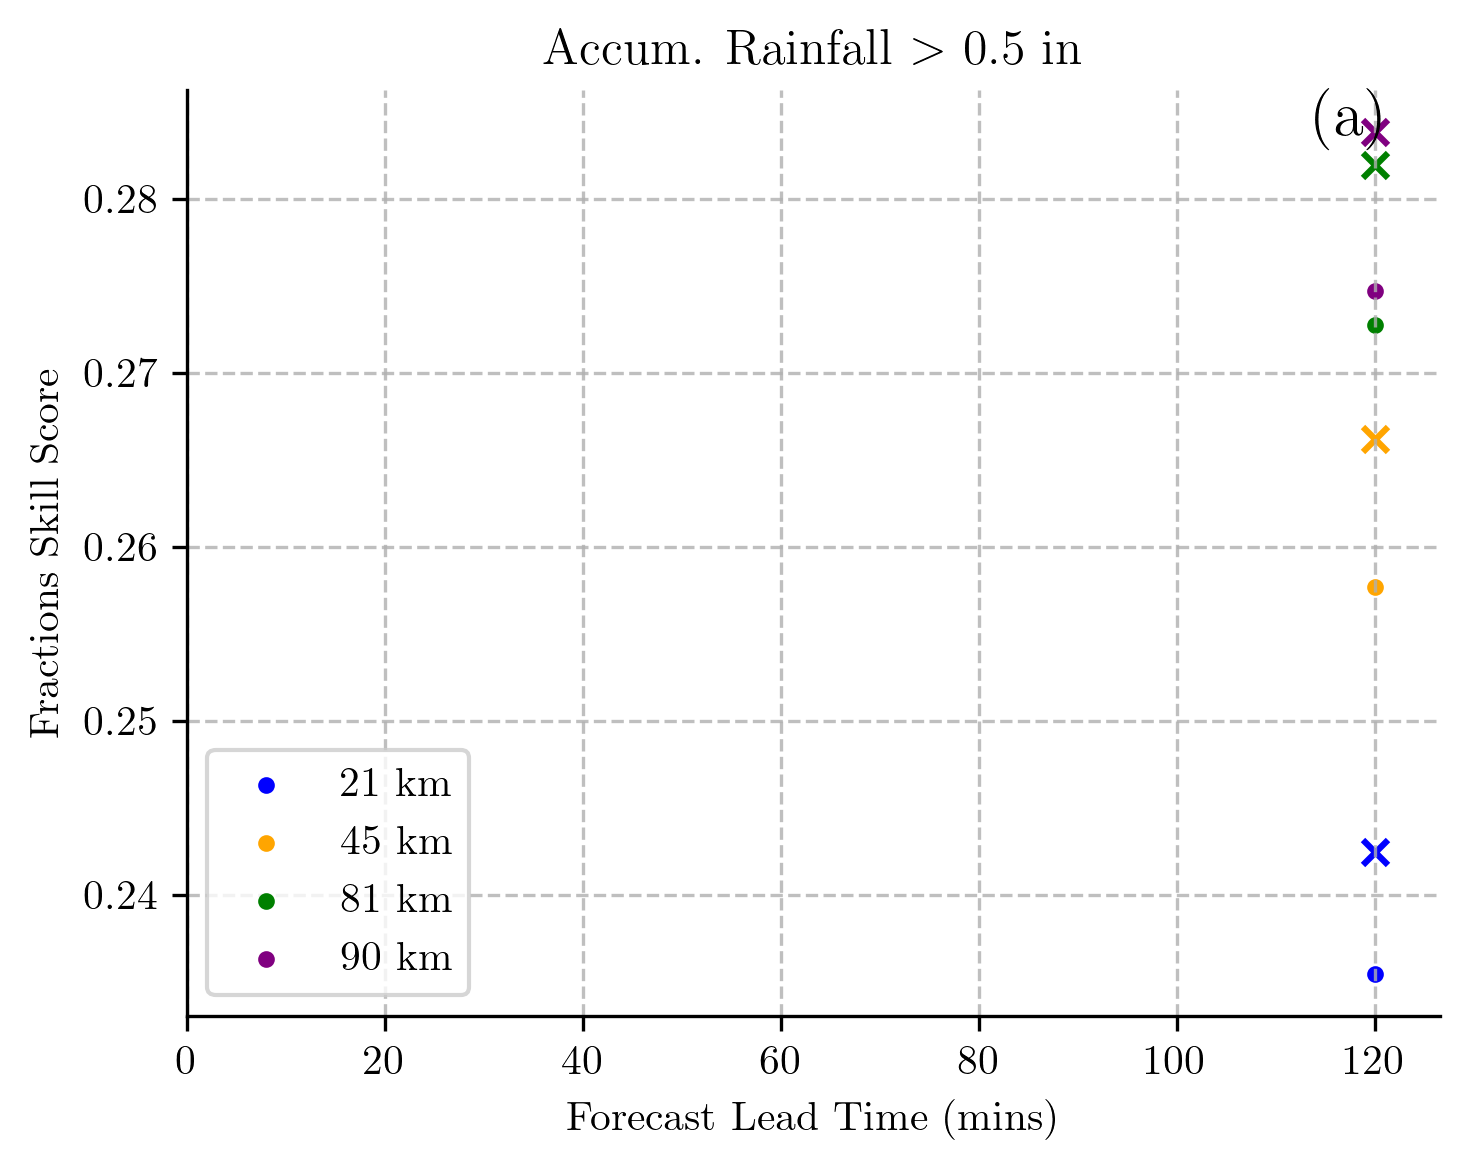

In [20]:
plotter.plot_fss(dataset_name, variables = ['accum_rain'], 
                 addons=['targets_vs_mrms', 'forecast_vs_mrms'])

## WoFS/WoFSCast vs. WoFS Analyses 

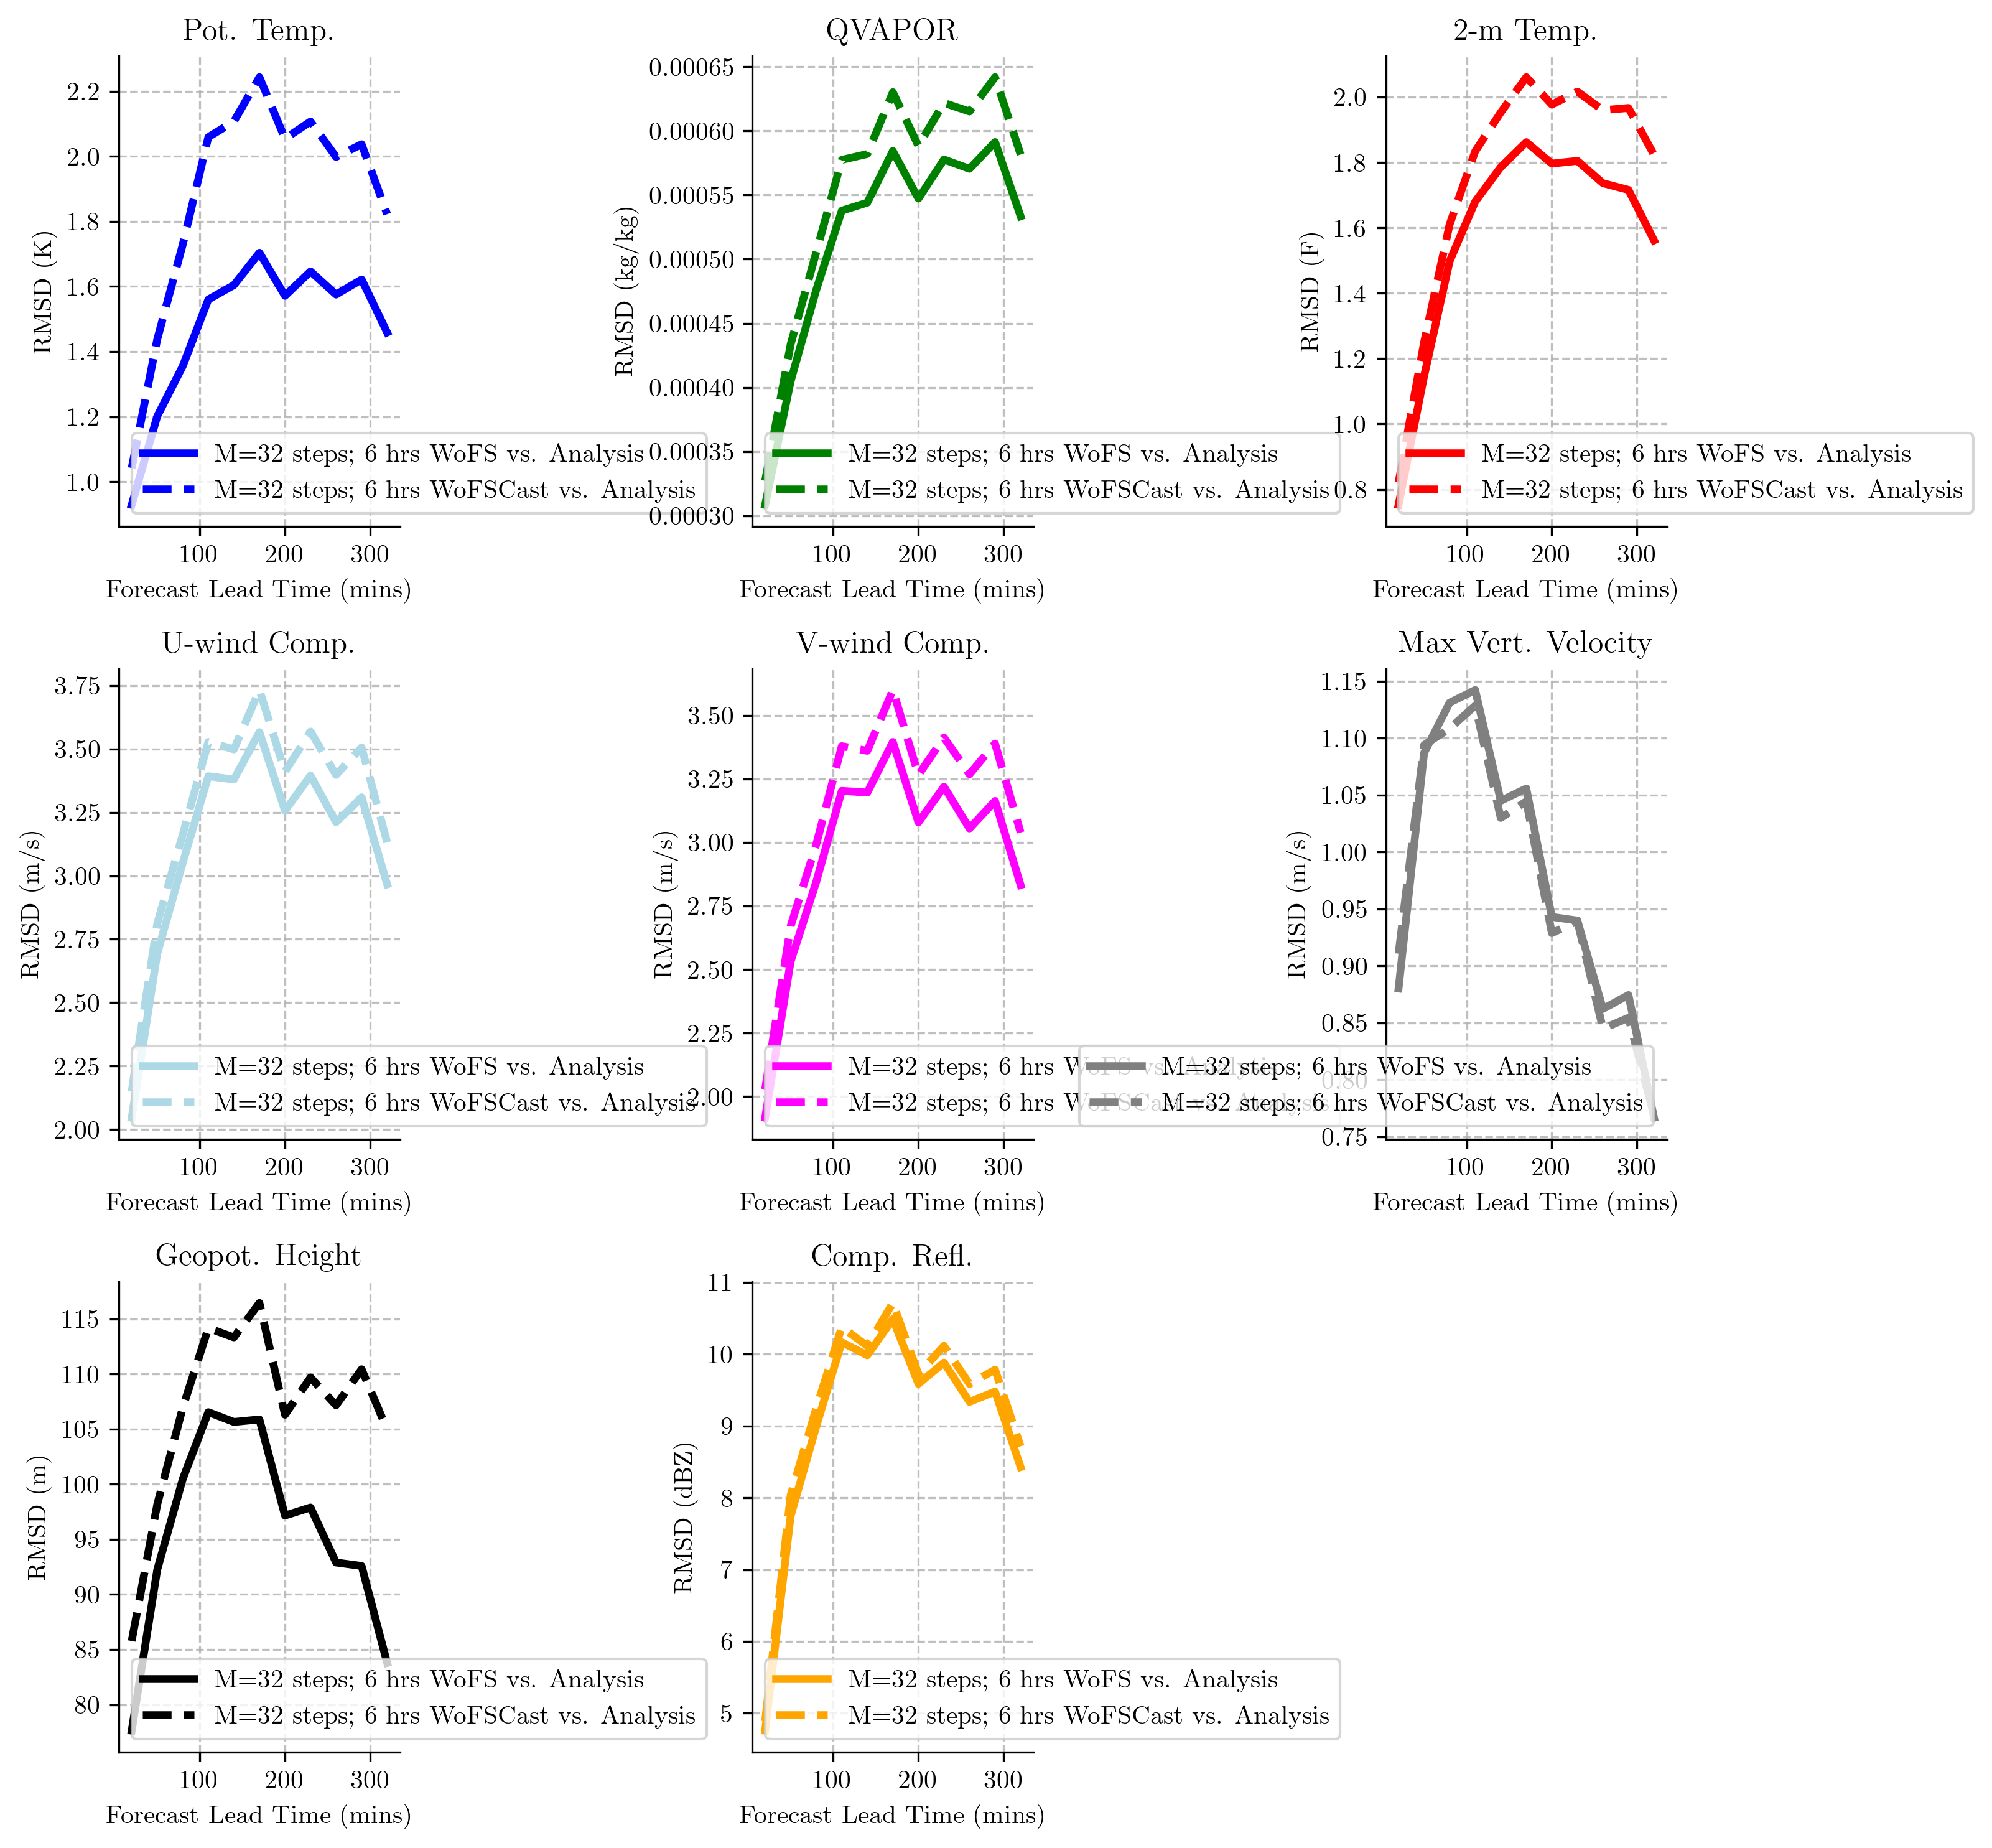

In [54]:
fig, axes = plotter.plot_analysis_rmse(dataset_name, variables = ['T', 'QVAPOR', 'T2', 
                  'U', 'V', 'WMAX',
                  'GEOPOT', 'COMPOSITE_REFL_10CM'
                 ])

axes[-1, -1].remove()
#plt.tight_layout()

## WoFS/WoFSCast vs. MRMS QPE (over 2 hr period)

In [22]:
fcst = datasets[dataset_name]['accum_rain_rmse_forecast_vs_mrms'].values
obs = datasets[dataset_name]['accum_rain_rmse_targets_vs_mrms'].values

print(f"WoFSCast vs. MRMS QPE: {fcst:.3f}")
print(f"WoFS vs. MRMS QPE: {obs:.3f}")

WoFSCast vs. MRMS QPE: 5.820
WoFS vs. MRMS QPE: 6.350
